# Import pkgs

In [1]:
import torch
import os
import sys
from pathlib import Path

file_dir = Path().absolute()
workspace_dir = os.path.dirname(file_dir)
sys.path.append(workspace_dir)
print(file_dir)
print(workspace_dir)

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
print('Pytorch version :', torch.__version__)
print('CUDA version\t:', torch.version.cuda)
print('GPU\t\t:',torch.cuda.get_device_name())

/data0/user/lxguo/Code/CATS-Net
/data0/user/lxguo/Code
Pytorch version : 2.0.1
CUDA version	: 11.7
GPU		: NVIDIA A40


In [2]:
from collections import OrderedDict, Counter
from A02_Semantic_Analysis.classes import IMAGENET2012_CLASSES
import torchvision
from A01_ImageNet import model, utils, data
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import scipy.io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from torch import nn
from pywaffle import Waffle
from scipy.spatial.distance import jensenshannon
from pypalettes import load_cmap
from matplotlib.colors import LinearSegmentedColormap
import scipy.stats as st
import scipy.stats
from scipy import stats

# Load data

In [3]:
# 30 * 1
try:
    acc_list_imagenet1k_ss20_fixfe_alltrails = torch.load("../Results/accuracy_list/acc_list_imagenet1k_ss20_fixfe_alltrails.pt")
except FileNotFoundError:
    print("Loading acc_list_imagenet1k_ss20_fixfe_alltrails from ./Results/")
    try:
        acc_list_imagenet1k_ss20_fixfe_alltrails = torch.load("./Results/accuracy_list/acc_list_imagenet1k_ss20_fixfe_alltrails.pt")
    except FileNotFoundError:
        print("Failed to load acc_list_imagenet1k_ss20_fixfe_alltrails from both locations.")
        acc_list_imagenet1k_ss20_fixfe_alltrails = None # Or handle error appropriately

# 30 * 1
try:
    acc_list_random_imagenet1k_ss20_fixfe_alltrails = torch.load("../Results/accuracy_list/acc_list_random_imagenet1k_ss20_fixfe_alltrails.pt")
except FileNotFoundError:
    print("Loading acc_list_random_imagenet1k_ss20_fixfe_alltrails from ./Results/")
    try:
        acc_list_random_imagenet1k_ss20_fixfe_alltrails = torch.load("./Results/accuracy_list/acc_list_random_imagenet1k_ss20_fixfe_alltrails.pt")
    except FileNotFoundError:
        print("Failed to load acc_list_random_imagenet1k_ss20_fixfe_alltrails from both locations.")
        acc_list_random_imagenet1k_ss20_fixfe_alltrails = None # Or handle error appropriately


# 1000 * 1
try:
    acc_list_imagenet1k_ss20_fixfe_trail50 = torch.load("../Results/accuracy_list/acc_list_imagenet1k_ss20_fixfe_trail50.pt")
except FileNotFoundError:
    print("Loading acc_list_imagenet1k_ss20_fixfe_trail50 from ./Results/")
    try:
        acc_list_imagenet1k_ss20_fixfe_trail50 = torch.load("./Results/accuracy_list/acc_list_imagenet1k_ss20_fixfe_trail50.pt")
    except FileNotFoundError:
        print("Failed to load acc_list_imagenet1k_ss20_fixfe_trail50 from both locations.")
        acc_list_imagenet1k_ss20_fixfe_trail50 = None # Or handle error appropriately


# 1000 * 1, from Get_acc_list.py
try:
    acc_list_random_imagenet1k_ss20_fixfe_trail50 = torch.load("../Results/accuracy_list/acc_list_random_imagenet1k_ss20_fixfe_trail50.pt")
except FileNotFoundError:
    print("Loading acc_list_random_imagenet1k_ss20_fixfe_trail50 from ./Results/")
    try:
        acc_list_random_imagenet1k_ss20_fixfe_trail50 = torch.load("./Results/accuracy_list/acc_list_random_imagenet1k_ss20_fixfe_trail50.pt")
    except FileNotFoundError:
        print("Failed to load acc_list_random_imagenet1k_ss20_fixfe_trail50 from both locations.")
        acc_list_random_imagenet1k_ss20_fixfe_trail50 = None # Or handle error appropriately

try:
    imagenet1k_hypercategory = torch.load("../Results/hypercategory/imagenet1k_hypercategory_v2.pt")
except FileNotFoundError:
    print("Loading imagenet1k_hypercategory from ./Results/")
    try:
        imagenet1k_hypercategory = torch.load("./Results/hypercategory/imagenet1k_hypercategory_v2.pt")
    except FileNotFoundError:
        print("Failed to load imagenet1k_hypercategory from both locations.")
        imagenet1k_hypercategory = None # Or handle error appropriately

try:
    cifar_df = pd.read_excel("../Results/single_ct_acc.xlsx")
except FileNotFoundError:
    print("Loading cifar_df from ./Results/")
    try:
        cifar_df = pd.read_excel("./Results/single_ct_acc.xlsx")
    except FileNotFoundError:
        print("Failed to load cifar_df from both locations.")
        cifar_df = pd.DataFrame() # Or handle error appropriately

try:
    Concept_VOTC_df = pd.read_csv("../Results/Concept_results.csv")
except FileNotFoundError:
    print("Loading Concept_VOTC_df from ./Results/")
    try:
        Concept_VOTC_df = pd.read_csv("./Results/Concept_results.csv")
    except FileNotFoundError:
        print("Failed to load Concept_VOTC_df from both locations.")
        Concept_VOTC_df = pd.DataFrame() # Or handle error appropriately

try:
    CA_control_df = pd.read_csv("../Results/CA_results.csv")
except FileNotFoundError:
    print("Loading CA_control_df from ./Results/")
    try:
        CA_control_df = pd.read_csv("./Results/CA_results.csv")
    except FileNotFoundError:
        print("Failed to load CA_control_df from both locations.")
        CA_control_df = pd.DataFrame() # Or handle error appropriately

try:
    Concept_bindersub_df = pd.read_csv("../Results/wt_subdomain_partialcorr.csv")
except FileNotFoundError:
    print("Loading Concept_bindersub_df from ./Results/")
    try:
        Concept_bindersub_df = pd.read_csv("./Results/wt_subdomain_partialcorr.csv")
    except FileNotFoundError:
        print("Failed to load Concept_bindersub_df from both locations.")
        Concept_bindersub_df = pd.DataFrame() # Or handle error appropriately

# Check if loading failed and handle appropriately
if acc_list_imagenet1k_ss20_fixfe_alltrails is not None and \
    acc_list_random_imagenet1k_ss20_fixfe_alltrails is not None and \
    acc_list_imagenet1k_ss20_fixfe_trail50 is not None and \
    acc_list_random_imagenet1k_ss20_fixfe_trail50 is not None and \
    not cifar_df.empty and \
    not Concept_VOTC_df.empty and \
    not CA_control_df.empty and \
    not Concept_bindersub_df.empty:
    
    cifar100_mani_acc = list(cifar_df['best_acc_1'].values)
    cifar100_comm_acc = list(cifar_df['best_acc_2'].values)
    cifar100_wordvec_acc = list(cifar_df['best_acc_wordvector'].values)

    # Filter for Concept and group, then extract PartialCorrelation --------------------
    concept_pcorr_votc = list(Concept_VOTC_df['PartialCorrelation'].values)
    concept_pcorr_interest = Concept_VOTC_df[
        (Concept_VOTC_df['Kmeans_partial_group'] == 'interest')
    ]['PartialCorrelation'].tolist()
    concept_pcorr_uninterest = Concept_VOTC_df[
        (Concept_VOTC_df['Kmeans_partial_group'] == 'uninterest')
    ]['PartialCorrelation'].tolist()

    # Filter for Concept and group, then extract binder_rho_fishZ --------------------
    concept_binder_rho = list(Concept_VOTC_df['binder_rho_fishZ'].values)
    concept_rho_interest = Concept_VOTC_df[
        (Concept_VOTC_df['Kmeans_partial_group'] == 'interest')
    ]['binder_rho_fishZ'].tolist()
    concept_rho_uninterest = Concept_VOTC_df[
        (Concept_VOTC_df['Kmeans_partial_group'] == 'uninterest')
    ]['binder_rho_fishZ'].tolist()
    

    # Filter for CA1 and Semantic Control, then extract Correlation --------------------
    ca1_semantic_corr = CA_control_df[
        (CA_control_df['Layer'] == 'cdp1') & 
        (CA_control_df['ROIName'] == 'Reslice3mm_Binary_Jackson2021_semantic_control_ALE_result')
    ]['Correlation'].tolist()

    # Filter for CA1 and General Control, then extract Correlation
    ca1_general_corr = CA_control_df[
        (CA_control_df['Layer'] == 'cdp1') & 
        (CA_control_df['ROIName'] == 'Reslice3mm_Binary_Federenko2013_MultiDemand_ROI')
    ]['Correlation'].tolist()

    # Filter for CA2 and Semantic Control, then extract Correlation --------------------
    ca2_semantic_corr = CA_control_df[
        (CA_control_df['Layer'] == 'cdp2') & 
        (CA_control_df['ROIName'] == 'Reslice3mm_Binary_Jackson2021_semantic_control_ALE_result')
    ]['Correlation'].tolist()

    # Filter for CA2 and General Control, then extract Correlation
    ca2_general_corr = CA_control_df[
        (CA_control_df['Layer'] == 'cdp2') & 
        (CA_control_df['ROIName'] == 'Reslice3mm_Binary_Federenko2013_MultiDemand_ROI')
    ]['Correlation'].tolist()

    # Filter for CA3 and Semantic Control, then extract Correlation --------------------
    ca3_semantic_corr = CA_control_df[
        (CA_control_df['Layer'] == 'cdp3') & 
        (CA_control_df['ROIName'] == 'Reslice3mm_Binary_Jackson2021_semantic_control_ALE_result')
    ]['Correlation'].tolist()

    # Filter for CA3 and General Control, then extract Correlation
    ca3_general_corr = CA_control_df[
        (CA_control_df['Layer'] == 'cdp3') & 
        (CA_control_df['ROIName'] == 'Reslice3mm_Binary_Federenko2013_MultiDemand_ROI')
    ]['Correlation'].tolist()

    # Concept for all 
    concept_bindersub_rho = []
    for i in range(2, len(Concept_bindersub_df.columns)):
        concept_bindersub_rho.append(Concept_bindersub_df.iloc[:, i].tolist())


else:
    # Handle the case where one or more files failed to load
    cifar100_mani_acc = []
    cifar100_comm_acc = []
    cifar100_wordvec_acc = []
    print("Error: One or more essential data files could not be loaded. Subsequent analysis might fail.")


Loading acc_list_imagenet1k_ss20_fixfe_alltrails from ./Results/
Loading acc_list_random_imagenet1k_ss20_fixfe_alltrails from ./Results/
Loading acc_list_imagenet1k_ss20_fixfe_trail50 from ./Results/
Loading acc_list_random_imagenet1k_ss20_fixfe_trail50 from ./Results/
Loading imagenet1k_hypercategory from ./Results/
Loading cifar_df from ./Results/
Loading Concept_VOTC_df from ./Results/
Loading CA_control_df from ./Results/
Loading Concept_bindersub_df from ./Results/


# Color Card

In [4]:
blue_hex = ['#d4e8ed', '#c1dce5', '#add4e5', '#96cae0', '#80c1d7', '#70bbd6', '#65bbd3', '#458da3']
purple_hex = ['#f4ecf4', '#d7c3df', '#b8a8cf', '#b396c8', '#9384be', '#734c81']
GREY_LIGHT = "#b4aea9"
GREY_DARK = "#747473"
GREY50 = "#7F7F7F"
waffle_hex = ['#ADD4E5', '#E7BCC6', '#F8C9C1', '#C0BBBE', '#BAC8E1']

# Fig 2aa - Acc of each classes, trail50

## histogram - trained CDP/TS

In [26]:
def interval_to_str(interval):
    start = interval.left
    end = interval.right
    if interval.closed_left:
        start_bracket = '['
    else:
        start_bracket = '('
    if interval.closed_right:
        end_bracket = ']'
    else:
        end_bracket = ')'
    return f"{start:.2f}~{end:.2f}"

min_val = min(min(acc_list_imagenet1k_ss20_fixfe_trail50), min(acc_list_random_imagenet1k_ss20_fixfe_trail50))
max_val = max(max(acc_list_imagenet1k_ss20_fixfe_trail50), max(acc_list_random_imagenet1k_ss20_fixfe_trail50))
interval_length = 0.02

bins = np.arange(min_val - interval_length, max_val, interval_length)

learned_concept_df = pd.cut(acc_list_imagenet1k_ss20_fixfe_trail50, bins, right=True, include_lowest=False).value_counts().sort_index()
random_concept_df = pd.cut(acc_list_random_imagenet1k_ss20_fixfe_trail50, bins, right=True, include_lowest=False).value_counts().sort_index()

learned_concept_df = learned_concept_df.reset_index()
learned_concept_df.columns = ['interval', 'count']

random_concept_df = random_concept_df.reset_index()
random_concept_df.columns = ['interval', 'count']

learned_concept_df['interval_str'] = learned_concept_df['interval'].apply(interval_to_str)
random_concept_df['interval_str'] = random_concept_df['interval'].apply(interval_to_str)


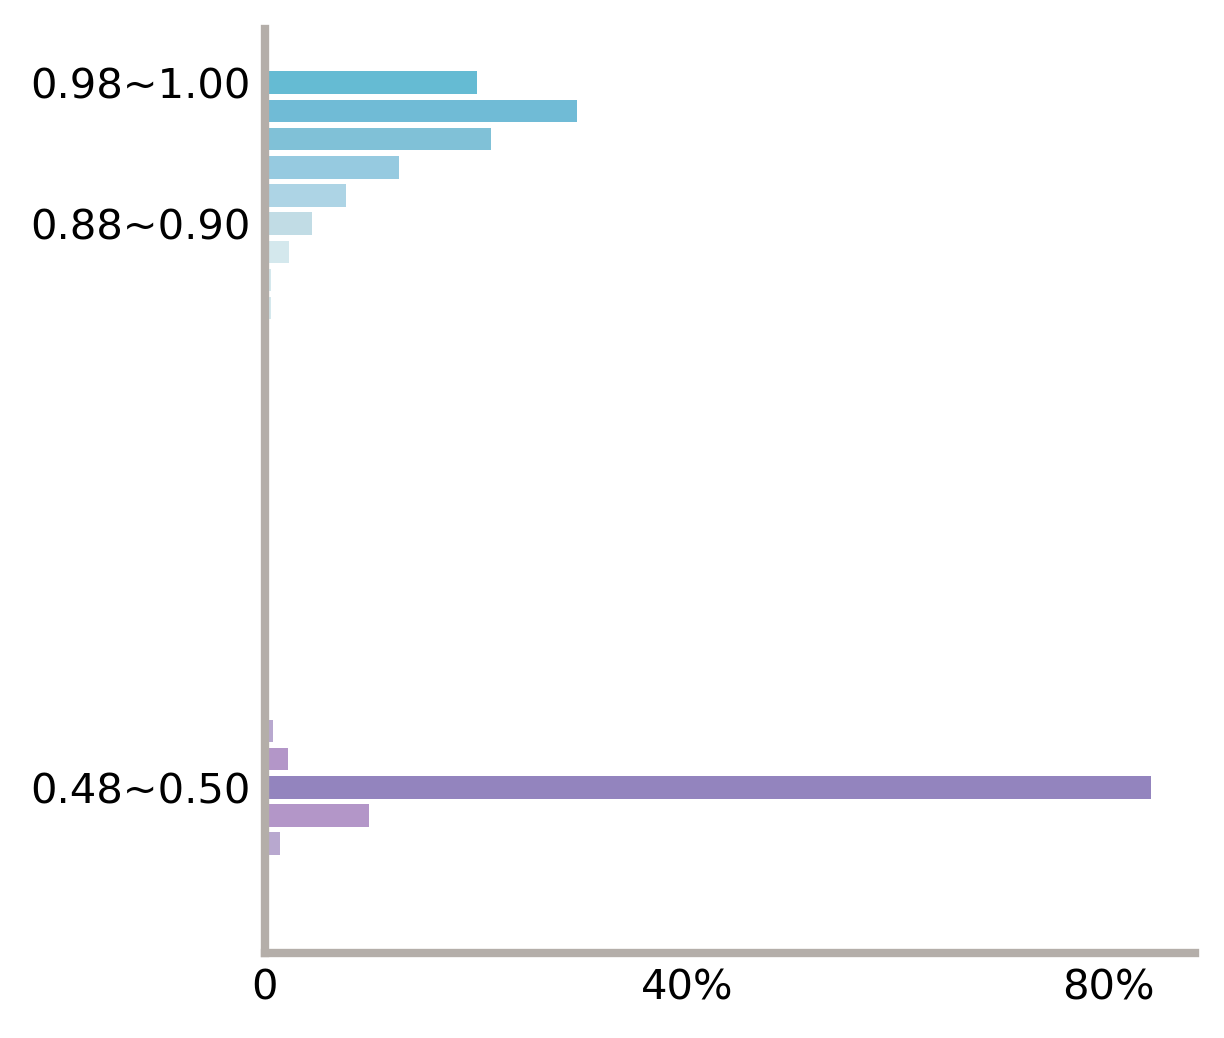

In [27]:
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

# Define colors to use for each bar
color_learned = [
    blue_hex[0], blue_hex[0], blue_hex[0], blue_hex[0], blue_hex[0],
    blue_hex[0], blue_hex[0], blue_hex[0], blue_hex[0], blue_hex[0],
    blue_hex[0], blue_hex[0], blue_hex[0], blue_hex[0], blue_hex[0],
    blue_hex[0], blue_hex[0], blue_hex[0], blue_hex[0], blue_hex[0],
    blue_hex[0], blue_hex[0], blue_hex[0], blue_hex[0], blue_hex[1],
    blue_hex[2], blue_hex[3], blue_hex[4], blue_hex[5], blue_hex[6],
]

color_random = [
    purple_hex[0], purple_hex[1], purple_hex[2], purple_hex[3], purple_hex[4], 
    purple_hex[3], purple_hex[2], purple_hex[1], purple_hex[0], purple_hex[0],
    purple_hex[0], purple_hex[0], purple_hex[0], purple_hex[0], purple_hex[0],
    purple_hex[0], purple_hex[0], purple_hex[0], purple_hex[0], purple_hex[0],
    purple_hex[0], purple_hex[0], purple_hex[0], purple_hex[0], purple_hex[0],
    purple_hex[0], purple_hex[0], purple_hex[0], purple_hex[0], purple_hex[0],
]

# Create the plot
ax.barh(
    learned_concept_df['interval_str'], 
    learned_concept_df['count'],
    color = color_learned, # colors that we want
    label='Learned Concepts'
)

# Create the plot
ax.barh(
    random_concept_df['interval_str'], 
    random_concept_df['count'],
    color = color_random, # colors that we want
    label='Random Concepts'
)

# Removes spines
ax.spines[['right', 'top']].set_visible(False)

# Add a vertical grey line at the relative position
ax.grid(
    linestyle='-', # type of lines
    alpha=0.0, # opacity
    axis='x', # specify that we only want vertical lines
)

ax.tick_params(axis='x', labelcolor=(0, 0, 0, 1), length = 0)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xticks([0, 400, 800])
ax.set_xticklabels(['0', '40%', '80%'])

ax.tick_params(axis='y', labelcolor=(0, 0, 0, 1), length = 0)
specific_ticks = [29, 24, 4]
ax.set_yticks(specific_ticks)

ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

plt.savefig("./B01_figures/outputs/fig_2aa.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_2aa.png", format="png", bbox_inches='tight')

plt.show()

In [ ]:
y_ticks = ax.get_yticks()  
y_labels = ax.get_yticklabels()  

for tick, label in zip(y_ticks, y_labels):
    print(f"y axis position: {tick}, range: {label.get_text()}")

# Fig 2ab - Acc of all classes, 30 trails

## bar + paired scatter

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


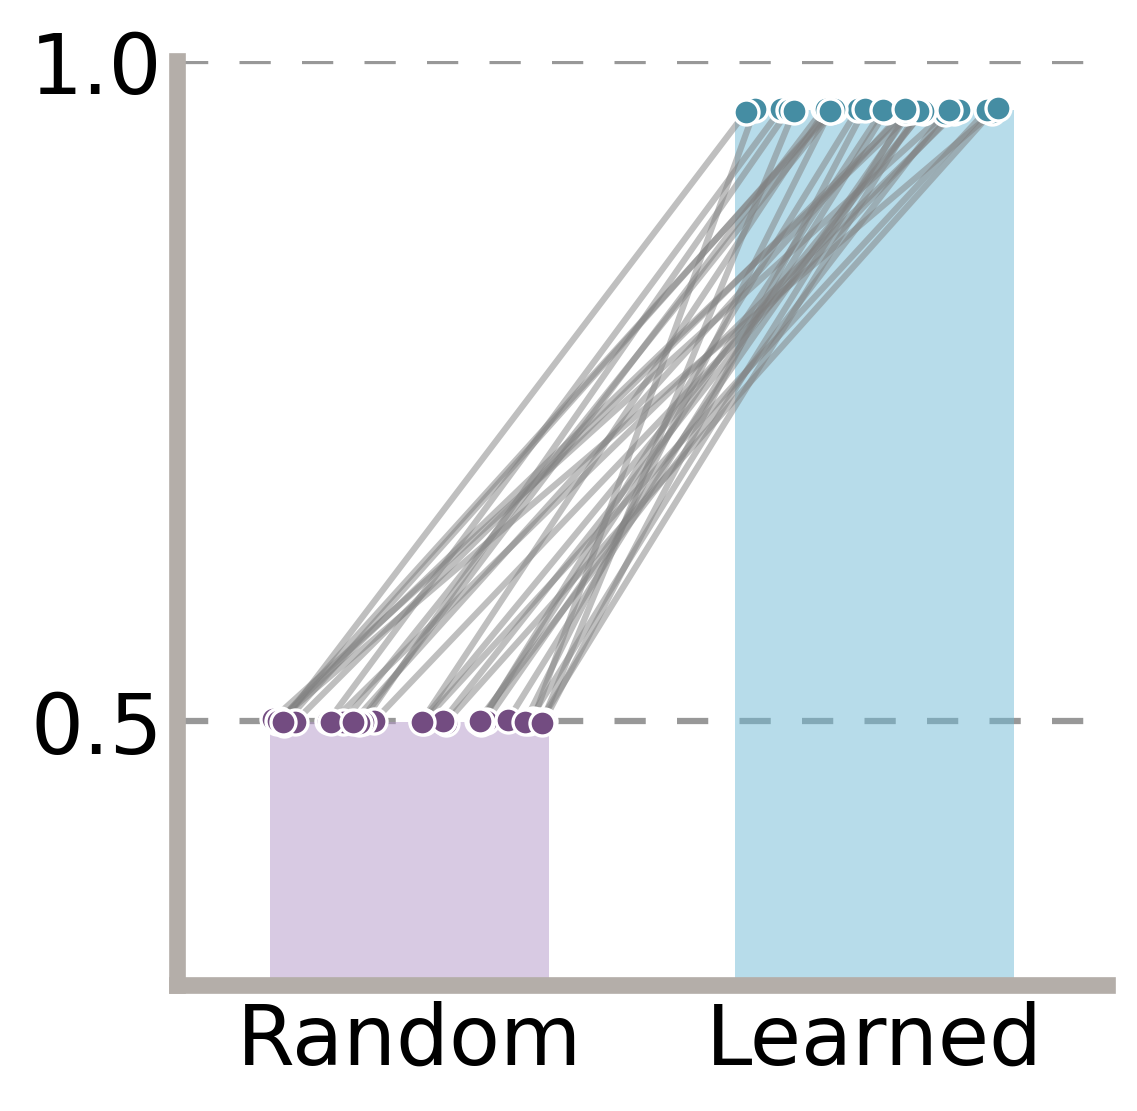

In [28]:
# Sample data
# np.random.seed(10)
group1 = np.array(acc_list_random_imagenet1k_ss20_fixfe_alltrails)
group2 = np.array(acc_list_imagenet1k_ss20_fixfe_alltrails)

# Create a DataFrame
data_30trails = pd.DataFrame({'Group1': group1, 'Group2': group2})

# Calculate means and standard errors
means = data_30trails.mean()

bar_width = 0.6
# Generate small random jitter
jitter = bar_width / 2

HLINES = [0.5, 1.0]

# Plot
fig, ax = plt.subplots(figsize = (4, 4), dpi=300)

# Bar plot with error bars
ax.bar([0, 1], means, color=[purple_hex[3], blue_hex[5]], alpha=0.5, capsize=1, width=bar_width)
x1 = np.zeros(len(group1)) + np.random.uniform(-jitter, jitter, len(group1))
x2 = np.ones(len(group2)) + np.random.uniform(-jitter, jitter, len(group2))
# Pairing data points and drawing lines with jitter
for i in range(data_30trails.shape[0]):
    x1_i = x1[i]
    x2_i = x2[i]
    ax.plot([x1_i, x2_i], data_30trails.iloc[i], color='gray', alpha=0.5)

# Scatter plot of individual data points with jitter
ax.scatter(x1, group1, color=purple_hex[5], edgecolors='white', linewidth=0.8, zorder=3)
ax.scatter(x2, group2, color=blue_hex[7], edgecolors='white', linewidth=0.8, zorder=3)

# Horizontal lines that are used as scale reference
for h in HLINES:
    ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Customizing the plot
ax.set_xticks([0, 1])
ax.set_xticklabels(['Random', 'Learned'], fontsize = 20)
# ax.tick_params(axis='x', labelrotation=45)
# for tick in ax.get_xticklabels():
#     tick.set_horizontalalignment('right')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(0.3, 1.0)
# ax.text(0.5, 1, 'Accuracy of all models', ha='center', va='bottom', fontsize=12)
# Removes spines
ax.spines[['right', 'top']].set_visible(False)

ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(4)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(4)

ax.tick_params(length=0, labelcolor=(0, 0, 0, 1))
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=20)

plt.savefig("./B01_figures/outputs/fig_2ab.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_2ab.png", format="png", bbox_inches='tight')

plt.show()


# Fig 2 c&d - Waffle plot for entropy

In [34]:
unique_hypercategory = sorted(list(set(imagenet1k_hypercategory.values())))
print(unique_hypercategory)

['instrumentality', 'mammal', 'others_animal', 'others_artifact', 'others_entity']


## Fig 2c - One-hot as concept, untrained sea-net

In [ ]:
net = model.sea_net(symbol_size = 20, num_classes = 1000, fix_fe = True, fe_type = 'resnet50', pretrain=True)

net.symbol_set.data = torch.rand(net.symbol_set.shape)

X_train = net.symbol_set.detach().numpy()

imagenet1k_test_FeatureDataset = data.FeatureDataset("../Results//FeatureData/ImageNet1k_test_embeddings.pt", "../Results/FeatureData/ImageNet1k_test_indices.pt")
imagenet1k_test_FeatureLoader = DataLoader(
    imagenet1k_test_FeatureDataset, 
    batch_size = 512, 
    num_workers = 8, 
    shuffle = False
)

net.to('cuda')
net.eval()

Imagenet1k_test_stat_Rands = torch.zeros([20, 1000])
Imagenet1k_test_stat_Rands_T = Imagenet1k_test_stat_Rands.T

for i in range(20):
    concept_i = torch.zeros(net.symbol_set[i].shape)
    concept_i[i] = 1.0

    print(f'Processing One-hot on random init sea-net')
    for X, y in imagenet1k_test_FeatureLoader:
        X = X.to('cuda')
        symbol_batch = concept_i.repeat([X.shape[0], 1]).to('cuda')
        y_hat = net.feature_forward(X, symbol_batch)
        y_hat = y_hat.to('cpu')
        mask = y_hat[:, 0] < y_hat[:, 1]
        indices_to_increment = y[mask]
        for j in range(len(y[mask])):
            Imagenet1k_test_stat_Rands[i, y[mask][j]] += 1

from collections import Counter

print(f'Counting number for each repeat: {Imagenet1k_test_stat_Rands.sum(dim=1).tolist()}')

Imagenet1k_test_stat_Rands_forWaffle = torch.zeros([20, len(unique_hypercategory)])

value_counts = Counter(imagenet1k_hypercategory.values())
sorted_value_counts = sorted(value_counts.items())
for value, count in sorted_value_counts:
    print(f"{value}: {count}")

for idx_pc in range(20):
    for i, value in enumerate(imagenet1k_hypercategory.values()):
        for j, hyper in enumerate(unique_hypercategory):
            if hyper == value:
                Imagenet1k_test_stat_Rands_forWaffle[idx_pc, j] += Imagenet1k_test_stat_Rands[idx_pc, i]

print(unique_hypercategory)
torch.save(Imagenet1k_test_stat_Rands_forWaffle, "../Results/entropy_stat/seanet_init_onehotconcept_waffle.pt")

Max counting value of symbols: 36297.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


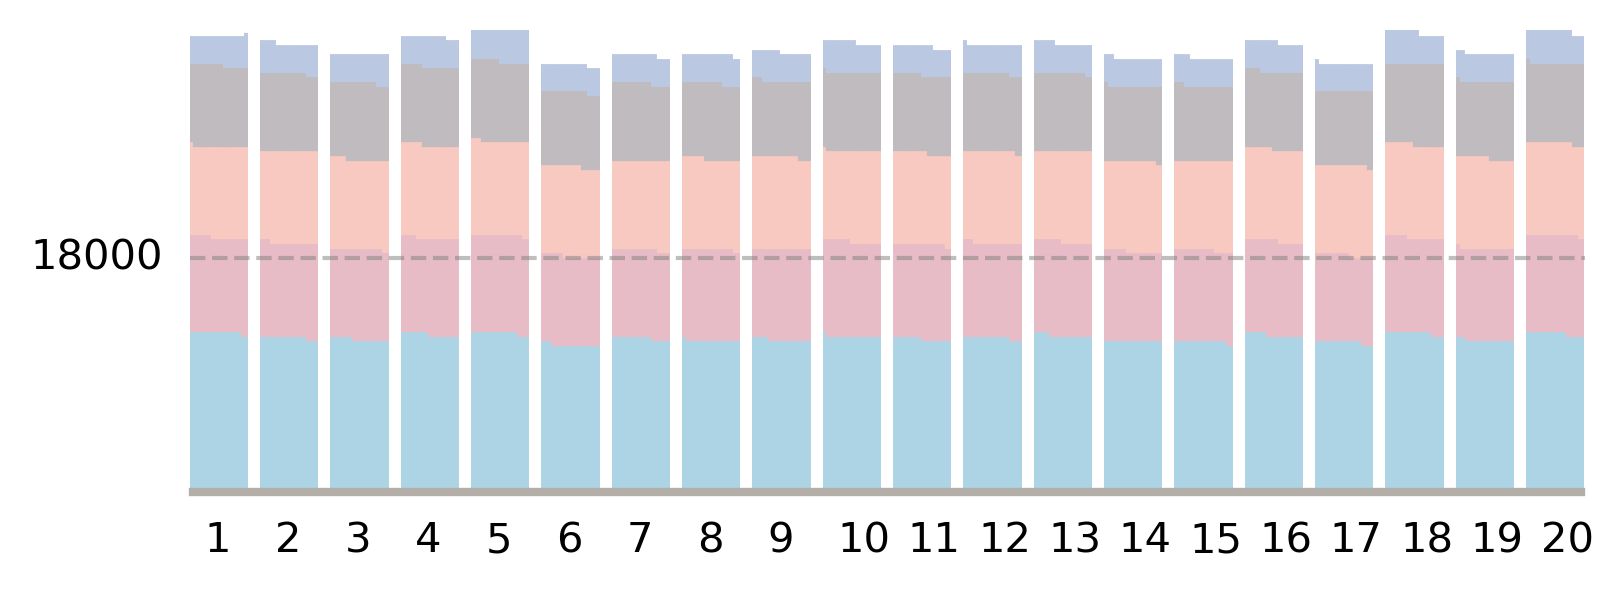

In [37]:
Imagenet1k_test_stat_Rands_forWaffle = torch.load("./Results/entropy_stat/seanet_init_onehotconcept_waffle.pt")

ncols = 20
fig, axs = plt.subplots(ncols=ncols, figsize=(6, 2), dpi=300)

count_max = Imagenet1k_test_stat_Rands_forWaffle.sum(dim = 1).max().item()
count_max_round = int(round(count_max / 1000) * 1000 / 2)

print(f'Max counting value of symbols: {count_max}')

for idx_pc, ax in enumerate(axs):
    values = Imagenet1k_test_stat_Rands_forWaffle[idx_pc].tolist()
    values.append(int(Imagenet1k_test_stat_Rands_forWaffle.sum(dim = 1).max().item()) - sum(values))
    Waffle.make_waffle(
        ax=ax,
        rows=100, 
        columns=10, 
        values=values,
        vertical=True,
        colors=[waffle_hex[0], waffle_hex[1], waffle_hex[2], waffle_hex[3], waffle_hex[4], 'white'] # imagenet1k_hypercategory_v2
    )
    ax.text(
        x=0.025, y=-0.13, s=str(idx_pc+1), fontsize=10, zorder=3
    )

bottom_line = plt.Line2D([0.127, 0.898], [0.11, 0.11], transform=fig.transFigure, color=GREY_LIGHT, linestyle='-', linewidth=2)
fig.add_artist(bottom_line)

line = plt.Line2D([0.125, 0.9], [0.5, 0.5], transform=fig.transFigure, color=GREY50, linestyle='--', linewidth=1.0, alpha=0.5)
fig.add_artist(line)
fig.text(0.11, 0.5, str(count_max_round), va='center', ha='right', transform=fig.transFigure, fontsize=10)

plt.savefig("./B01_figures/outputs/fig_2c.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_2c.png", format="png", bbox_inches='tight')

plt.show()

## Fig 2d - One-hot as concept, trained sea-net, hyper stat

In [ ]:
net_global_id = 50
net = model.sea_net(symbol_size = 20, num_classes = 1000, fix_fe = True, fe_type = 'resnet50')
net.load_state_dict(torch.load(f'../Results/param/imagenet1k_ss20_fixfe_trail{20+i}.pt'), strict=True)

net.symbol_set.data = torch.rand(net.symbol_set.shape)

X_train = net.symbol_set.detach().numpy()

imagenet1k_test_FeatureDataset = data.FeatureDataset("../Results/FeatureData/ImageNet1k_test_embeddings.pt", "../Results/FeatureData/ImageNet1k_test_indices.pt")
imagenet1k_test_FeatureLoader = DataLoader(
    imagenet1k_test_FeatureDataset, 
    batch_size = 512, 
    num_workers = 8, 
    shuffle = False
)

net.to('cuda')
net.eval()

Imagenet1k_test_stat_Rands = torch.zeros([20, 1000])
Imagenet1k_test_stat_Rands_T = Imagenet1k_test_stat_Rands.T

for i in range(20):
    concept_i = torch.zeros(net.symbol_set[i].shape)
    concept_i[i] = 1.0

    print(f'Processing One-hot {i}')
    for X, y in imagenet1k_test_FeatureLoader:
        X = X.to('cuda')
        symbol_batch = concept_i.repeat([X.shape[0], 1]).to('cuda')
        y_hat = net.feature_forward(X, symbol_batch)
        y_hat = y_hat.to('cpu')
        mask = y_hat[:, 0] < y_hat[:, 1]
        indices_to_increment = y[mask]
        for j in range(len(y[mask])):
            Imagenet1k_test_stat_Rands[i, y[mask][j]] += 1

from collections import Counter

print(f'Counting number for each category: {Imagenet1k_test_stat_Rands.sum(dim=1).tolist()}')

Imagenet1k_test_stat_Rands_forWaffle = torch.zeros([20, len(unique_hypercategory)])

value_counts = Counter(imagenet1k_hypercategory.values())
sorted_value_counts = sorted(value_counts.items())
for value, count in sorted_value_counts:
    print(f"{value}: {count}")

for idx_pc in range(20):
    for i, value in enumerate(imagenet1k_hypercategory.values()):
        for j, hyper in enumerate(unique_hypercategory):
            if hyper == value:
                Imagenet1k_test_stat_Rands_forWaffle[idx_pc, j] += Imagenet1k_test_stat_Rands[idx_pc, i]

print(unique_hypercategory)
torch.save(Imagenet1k_test_stat_Rands_forWaffle, f"../Results/entropy_stat/seanet{net_global_id}_onehotconcept_waffle.pt")


Max counting value of symbols: 4480.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


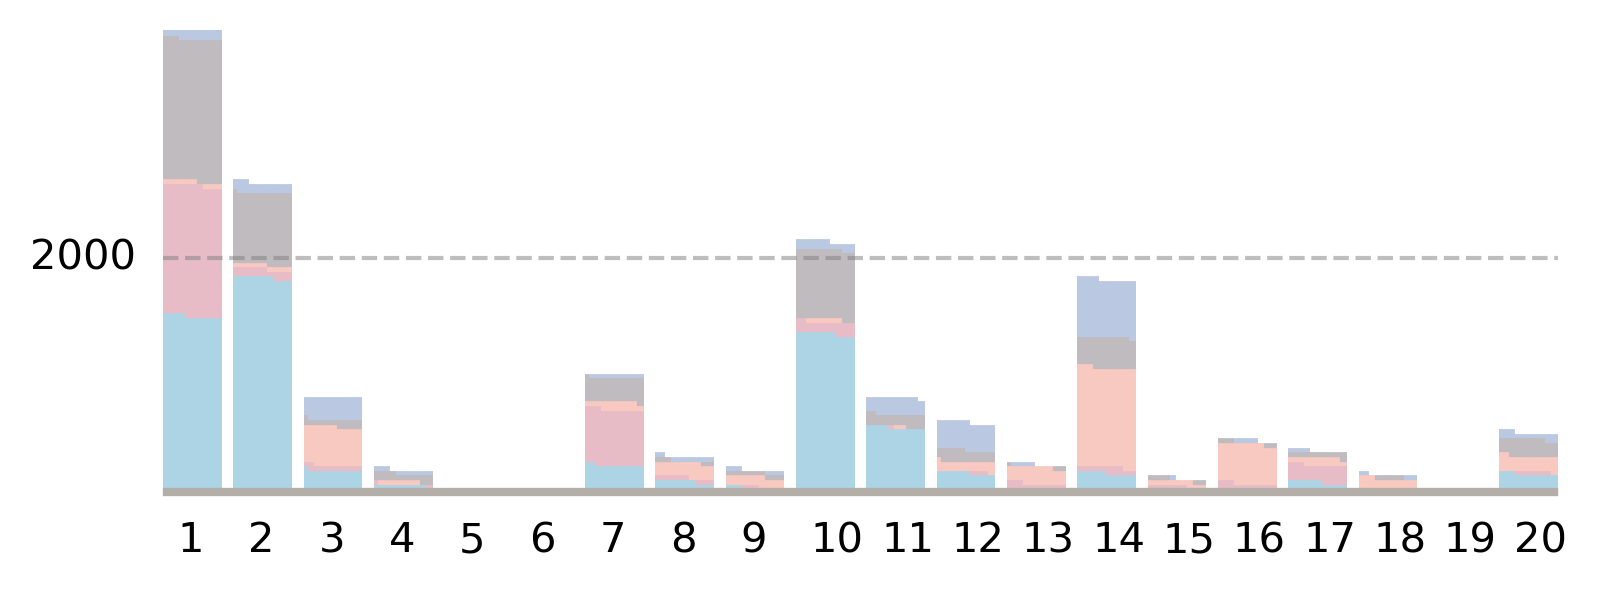

In [38]:
net_global_id = 50
Imagenet1k_test_stat_Rands_forWaffle = torch.load(f"./Results/entropy_stat/seanet{net_global_id}_onehotconcept_waffle.pt")

ncols = 20
fig, axs = plt.subplots(ncols=ncols, figsize=(6, 2), dpi=300)

count_max = Imagenet1k_test_stat_Rands_forWaffle.sum(dim = 1).max().item()
count_max_round = int(round(count_max / 1000) * 1000 / 2)

print(f'Max counting value of symbols: {count_max}')

for idx_pc, ax in enumerate(axs):
    values = Imagenet1k_test_stat_Rands_forWaffle[idx_pc].tolist()
    values.append(int(Imagenet1k_test_stat_Rands_forWaffle.sum(dim = 1).max().item()) - sum(values))
    Waffle.make_waffle(
        ax=ax,
        rows=100, 
        columns=10, 
        values=values,
        vertical=True,
        colors=[waffle_hex[0], waffle_hex[1], waffle_hex[2], waffle_hex[3], waffle_hex[4], 'white'] # imagenet1k_hypercategory_v2
    )
    ax.text(
        x=0.025, y=-0.13, s=str(idx_pc+1), fontsize=10, zorder=3
    )

bottom_line = plt.Line2D([0.127, 0.898], [0.11, 0.11], transform=fig.transFigure, color=GREY_LIGHT, linestyle='-', linewidth=2)
fig.add_artist(bottom_line)

line = plt.Line2D([0.125, 0.9], [0.5, 0.5], transform=fig.transFigure, color=GREY50, linestyle='--', linewidth=1.0, alpha=0.5)
fig.add_artist(line)
fig.text(0.11, 0.5, str(count_max_round), va='center', ha='right', transform=fig.transFigure, fontsize=10)

plt.savefig("./B01_figures/outputs/fig_2d.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_2d.png", format="png", bbox_inches='tight')

plt.show()

# Fig 2f - Entropy dist Rand concept vs Rand TS

In [41]:
def get_non_zero_values(input_tensor):
    return input_tensor[input_tensor != 0.0]

def get_entropy(normalized_prob, eps = None):
    if eps == None:
        non_zero_normalized_prob = get_non_zero_values(normalized_prob)
    else:
        non_zero_normalized_prob = torch.clamp(normalized_prob, min = eps)
    return -torch.sum(non_zero_normalized_prob * torch.log2(non_zero_normalized_prob))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


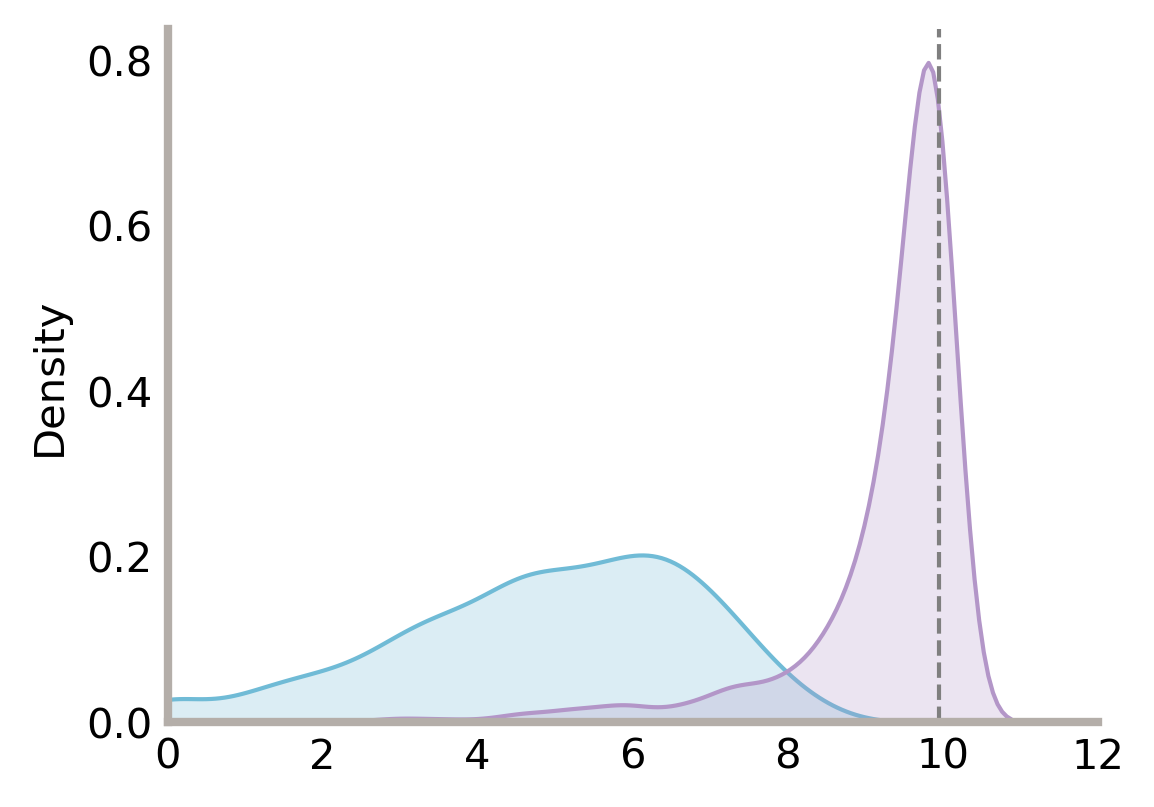

In [42]:
net_global_id = 50
Imagenet1k_test_stat_trainedConfig = torch.load(f"./Results/entropy_stat/Imagenet1k_test_stat_seanet{50}_trainedConfig.pt")
prob_trainedConfig = Imagenet1k_test_stat_trainedConfig * 0.02
sumprob_trainedConfig = prob_trainedConfig.sum(dim = 1, keepdim = True)
mask_trainedConfig = sumprob_trainedConfig.squeeze() != 0.0
normalized_trainedConfig = prob_trainedConfig / sumprob_trainedConfig
normalized_trainedConfig = normalized_trainedConfig[mask_trainedConfig]
entropy_trainedConfig = torch.zeros(normalized_trainedConfig.shape[0])
for i in range(normalized_trainedConfig.shape[0]): # prob_randomConfig.shape[0]
    selected_normalized_trainedConfig = normalized_trainedConfig[i]
    entropy_trainedConfig[i] = get_entropy(selected_normalized_trainedConfig)

Imagenet1k_test_stat_randomConfig = torch.load(f"./Results/entropy_stat/Imagenet1k_test_stat_tsnet_randomConfig.pt")
prob_randomConfig = Imagenet1k_test_stat_randomConfig * 0.02
sumprob_randomConfig = prob_randomConfig.sum(dim = 1, keepdim = True)
mask_randomConfig = sumprob_randomConfig.squeeze() != 0.0
normalized_randomConfig = prob_randomConfig / sumprob_randomConfig
normalized_randomConfig = normalized_randomConfig[mask_randomConfig]
entropy_randomConfig = torch.zeros(normalized_randomConfig.shape[0])

for i in range(normalized_randomConfig.shape[0]):
    selected_normalized_randomConfig = normalized_randomConfig[i]
    entropy_randomConfig[i] = get_entropy(selected_normalized_randomConfig)

fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
list1 = entropy_trainedConfig.tolist()
list2 = entropy_randomConfig.tolist()
bandwidth = 1.0
kde = sns.kdeplot(
    list1,
    fill = True,
    bw_adjust = bandwidth,
    ax = ax,
    color = blue_hex[5],
)

kde = sns.kdeplot(
    list2,
    fill = True,
    bw_adjust = bandwidth,
    ax = ax,
    color = purple_hex[3],
)

ax.tick_params(axis='x', labelcolor=(0, 0, 0, 1), length = 0)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlim(0, 12)
ax.tick_params(axis='y', labelcolor=(0, 0, 0, 1), length = 0)
# ax.set_yticks([0, 35, 70])
# ax.set_yticks(specific_ticks)

ax.axvline(9.96, color = GREY50, linestyle='--', linewidth = 1.0)
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)
ax.spines[['right', 'top']].set_visible(False)


plt.savefig("./B01_figures/outputs/fig_2f.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_2f.png", format="png", bbox_inches='tight')

plt.show()

# Fig 3e & Fig 4b Mean acc comm. and word2vec

## Fig 3e vertical comm.

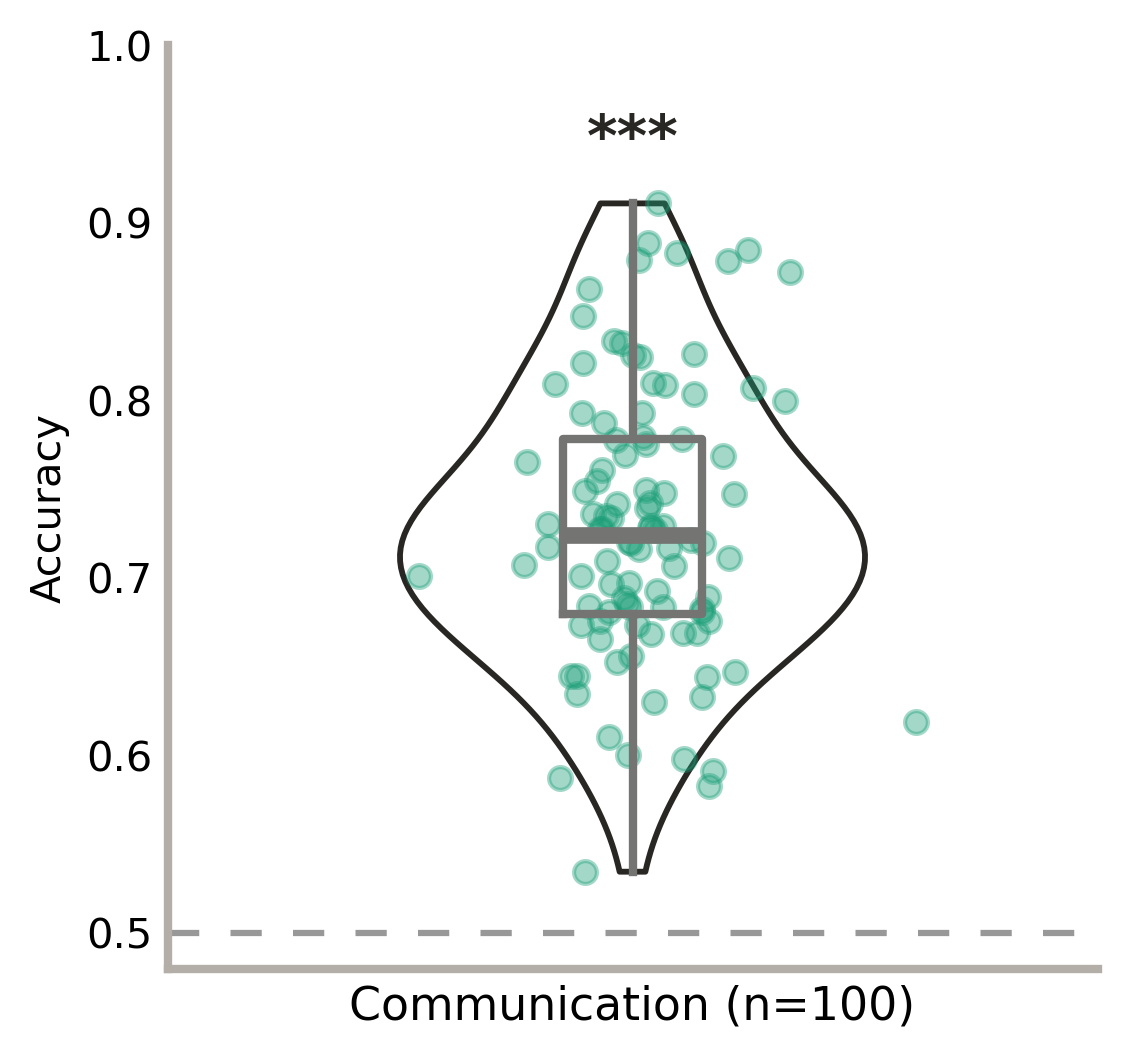

In [4]:
# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [cifar100_comm_acc]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.06
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
HLINES = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

fig, ax = plt.subplots(figsize= (4, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    if h == 0.5: ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.5,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.4)

max_y = max(y_data[0])
offset = 0.02
ax.text(POSITIONS[0], max_y + offset, "***", ha='center', va='bottom', weight="bold", fontsize=14, color=BLACK)


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Accuracy", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["Communication (n=100)"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")

# plt.savefig("./B01_figures/outputs/fig_3e.eps", format="eps", bbox_inches='tight')
# plt.savefig("./B01_figures/outputs/fig_3e.png", format="png", bbox_inches='tight')

plt.show()

In [8]:
# Extract the two lists
sample1 = y_data[0]

# --- Test 1: Check if the mean of each sample is significantly greater than zero ---
# We use a one-sample t-test.
# H0: The mean of the sample is equal to 0.
# H1: The mean of the sample is greater than 0.

print("--- One-sample t-tests (mean > 0) ---")
alpha = 0.05 # Significance level

threshold = 0.7
# For sample 1
# The 'alternative' parameter is set to 'greater' for a one-sided test.
t_statistic_s1, p_value_s1 = stats.ttest_1samp(sample1, threshold, alternative='greater')
print(f"Sample 1: t-statistic = {t_statistic_s1:.4f}, p-value = {p_value_s1:.4f}")
print(f'mean {np.mean(sample1):.4f}, std {np.std(sample1):.4f}')
if p_value_s1 < alpha:
    print(f"  The mean of Sample 1 is significantly greater than {threshold:.4f}")
else:
    print(f"  There is not enough evidence to say the mean of Sample 1 is significantly greater than {threshold:.4f}")

print("-" * 40)


--- One-sample t-tests (mean > 0) ---
Sample 1: t-statistic = 3.7428, p-value = 0.0002
mean 0.7292, std 0.0778
  The mean of Sample 1 is significantly greater than 0.7000
----------------------------------------


## Fig 4b vertical word2vec

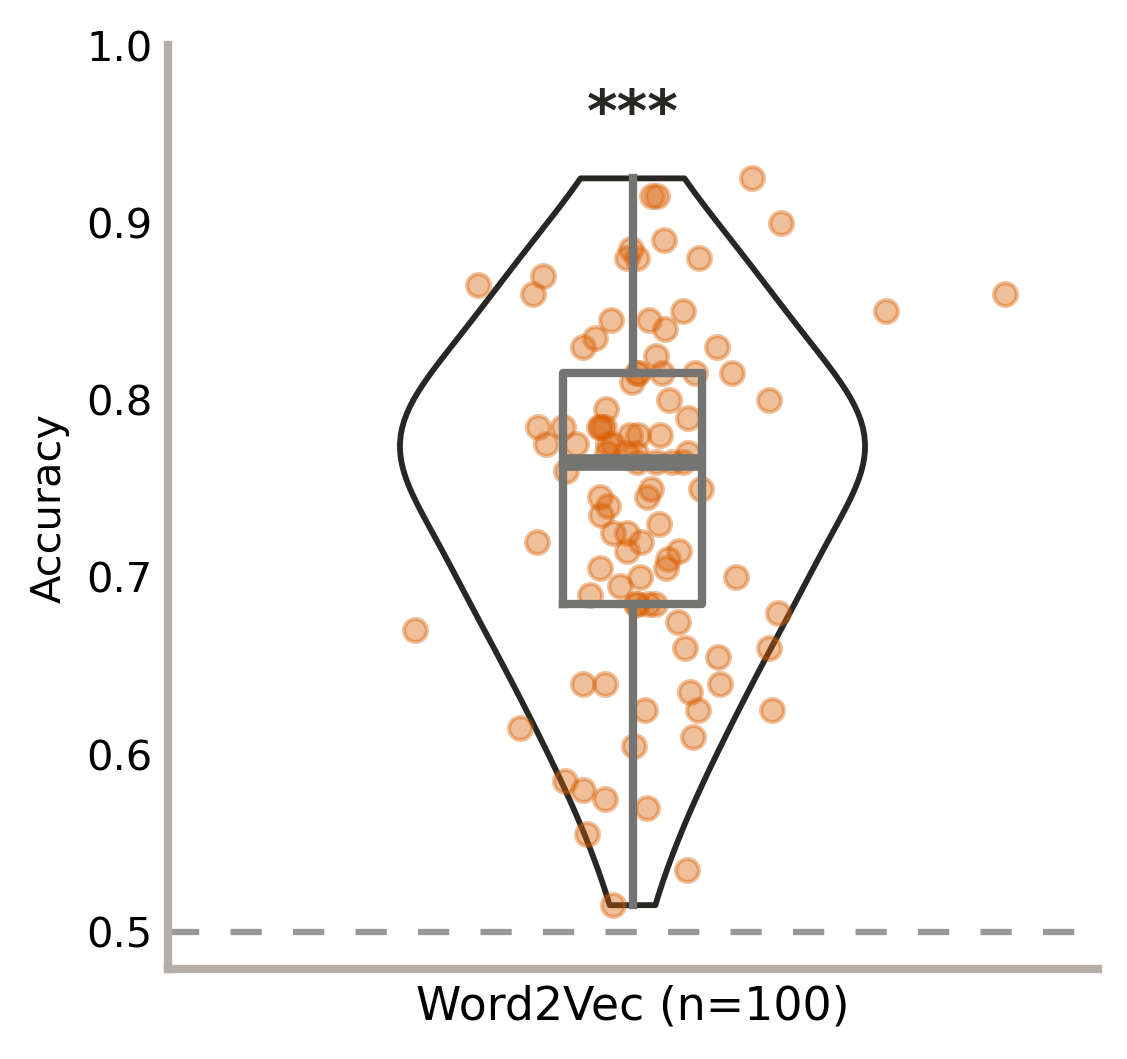

In [9]:
# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [cifar100_wordvec_acc]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.06
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#D95F02", "#7570B3"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
HLINES = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

fig, ax = plt.subplots(figsize= (4, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    if h == 0.5: ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.5,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.4)

max_y = max(y_data[0])
offset = 0.02
ax.text(POSITIONS[0], max_y + offset, "***", ha='center', va='bottom', weight="bold", fontsize=14, color=BLACK)


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Accuracy", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["Word2Vec (n=100)"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")

# plt.savefig("./B01_figures/outputs/fig_4b.eps", format="eps", bbox_inches='tight')
# plt.savefig("./B01_figures/outputs/fig_4b.png", format="png", bbox_inches='tight')

plt.show()

In [10]:
# Extract the two lists
sample1 = y_data[0]

# --- Test 1: Check if the mean of each sample is significantly greater than zero ---
# We use a one-sample t-test.
# H0: The mean of the sample is equal to 0.
# H1: The mean of the sample is greater than 0.

print("--- One-sample t-tests (mean > 0) ---")
alpha = 0.05 # Significance level

threshold = 0.7
# For sample 1
# The 'alternative' parameter is set to 'greater' for a one-sided test.
t_statistic_s1, p_value_s1 = stats.ttest_1samp(sample1, threshold, alternative='greater')
print(f"Sample 1: t-statistic = {t_statistic_s1:.4f}, p-value = {p_value_s1:.4f}")
print(f'mean {np.mean(sample1):.4f}, std {np.std(sample1):.4f}')
if p_value_s1 < alpha:
    print(f"  The mean of Sample 1 is significantly greater than {threshold:.4f}")
else:
    print(f"  There is not enough evidence to say the mean of Sample 1 is significantly greater than {threshold:.4f}")

print("-" * 40)


--- One-sample t-tests (mean > 0) ---
Sample 1: t-statistic = 5.0827, p-value = 0.0000
mean 0.7474, std 0.0929
  The mean of Sample 1 is significantly greater than 0.7000
----------------------------------------


# Fig 5c_left Concept pcorr VOTC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


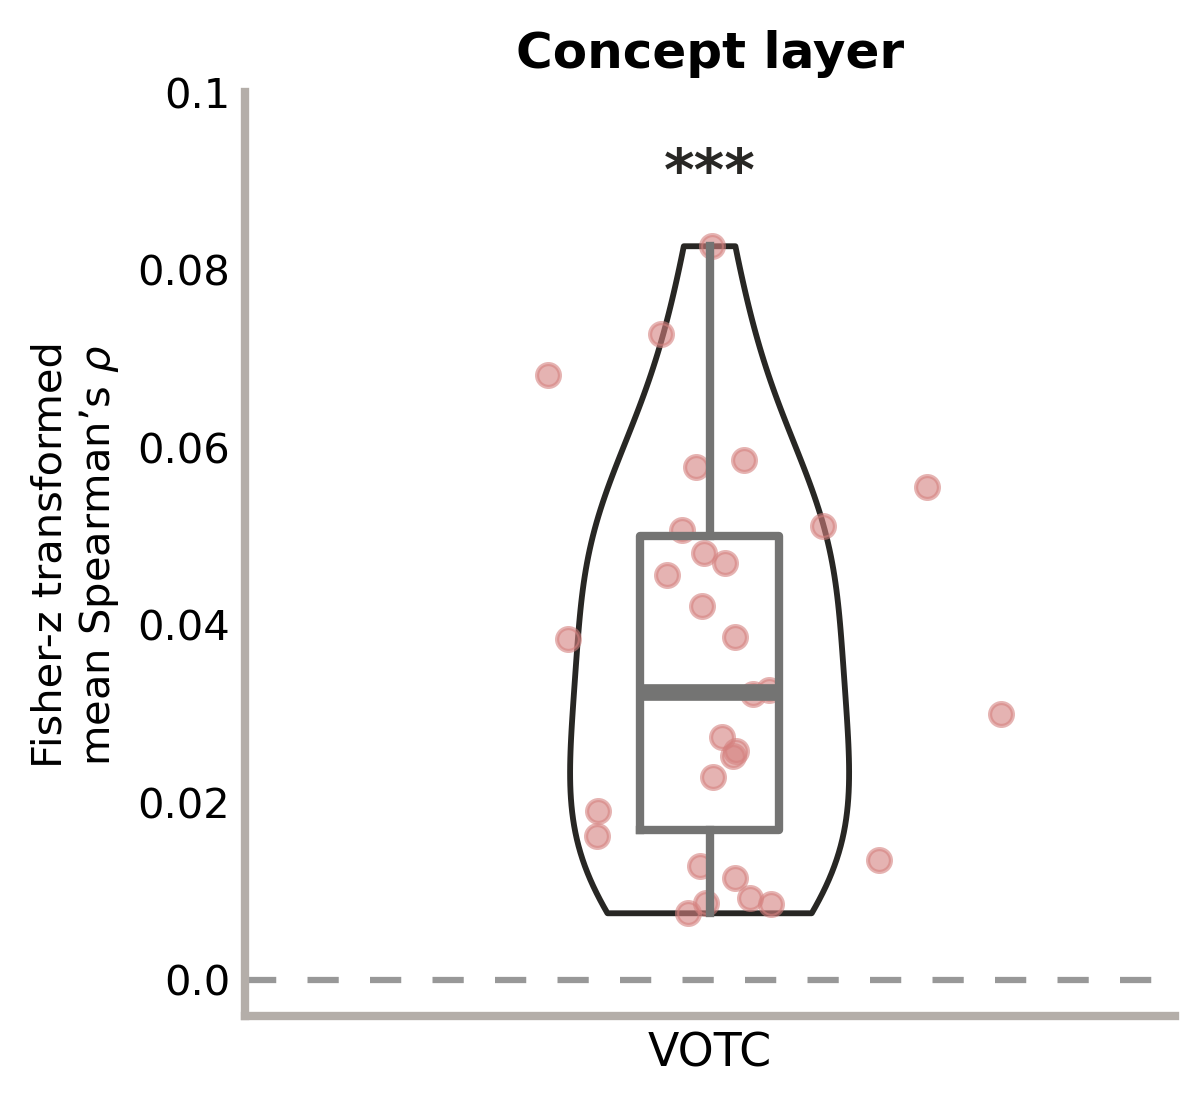

In [101]:
# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [concept_pcorr_votc]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.07
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#D5817F"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
HLINES = [0.0, 0.02, 0.04, 0.06, 0.08, 0.10]

fig, ax = plt.subplots(figsize= (4, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    if h == 0.0: ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.3,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.6)

max_y = max(y_data[0])
offset = 0.005
ax.text(POSITIONS[0], max_y + offset, "***", ha='center', va='bottom', weight="bold", fontsize=14, color=BLACK)


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Fisher-z transformed\nmean Spearman’s "r"$\rho$", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["VOTC"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")
plt.title("Concept layer", size=12, weight="bold")

plt.savefig("./B01_figures/outputs/fig_5c_left.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_5c_left.png", format="png", bbox_inches='tight')

plt.show()

In [23]:
# Extract the two lists
sample1 = y_data[0]

# --- Test 1: Check if the mean of each sample is significantly greater than zero ---
# We use a one-sample t-test.
# H0: The mean of the sample is equal to 0.
# H1: The mean of the sample is greater than 0.

print("--- One-sample t-tests (mean > 0) ---")
alpha = 0.05 # Significance level

# For sample 1
# The 'alternative' parameter is set to 'greater' for a one-sided test.
t_statistic_s1, p_value_s1 = stats.ttest_1samp(sample1, 0, alternative='greater')
print(f"Sample 1: t-statistic = {t_statistic_s1:.4f}, p-value = {p_value_s1:.4f}")
print(f'mean {np.mean(sample1):.2f}, std {np.std(sample1):.2f}')
if p_value_s1 < alpha:
    print("  The mean of Sample 1 is significantly greater than 0.")
else:
    print("  There is not enough evidence to say the mean of Sample 1 is significantly greater than 0.")

print("-" * 40)


--- One-sample t-tests (mean > 0) ---
Sample 1: t-statistic = 9.2686, p-value = 0.0000
mean 0.04, std 0.02
  The mean of Sample 1 is significantly greater than 0.
----------------------------------------


# Fig 5c_right CA1 pcorr semantic vs. general

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


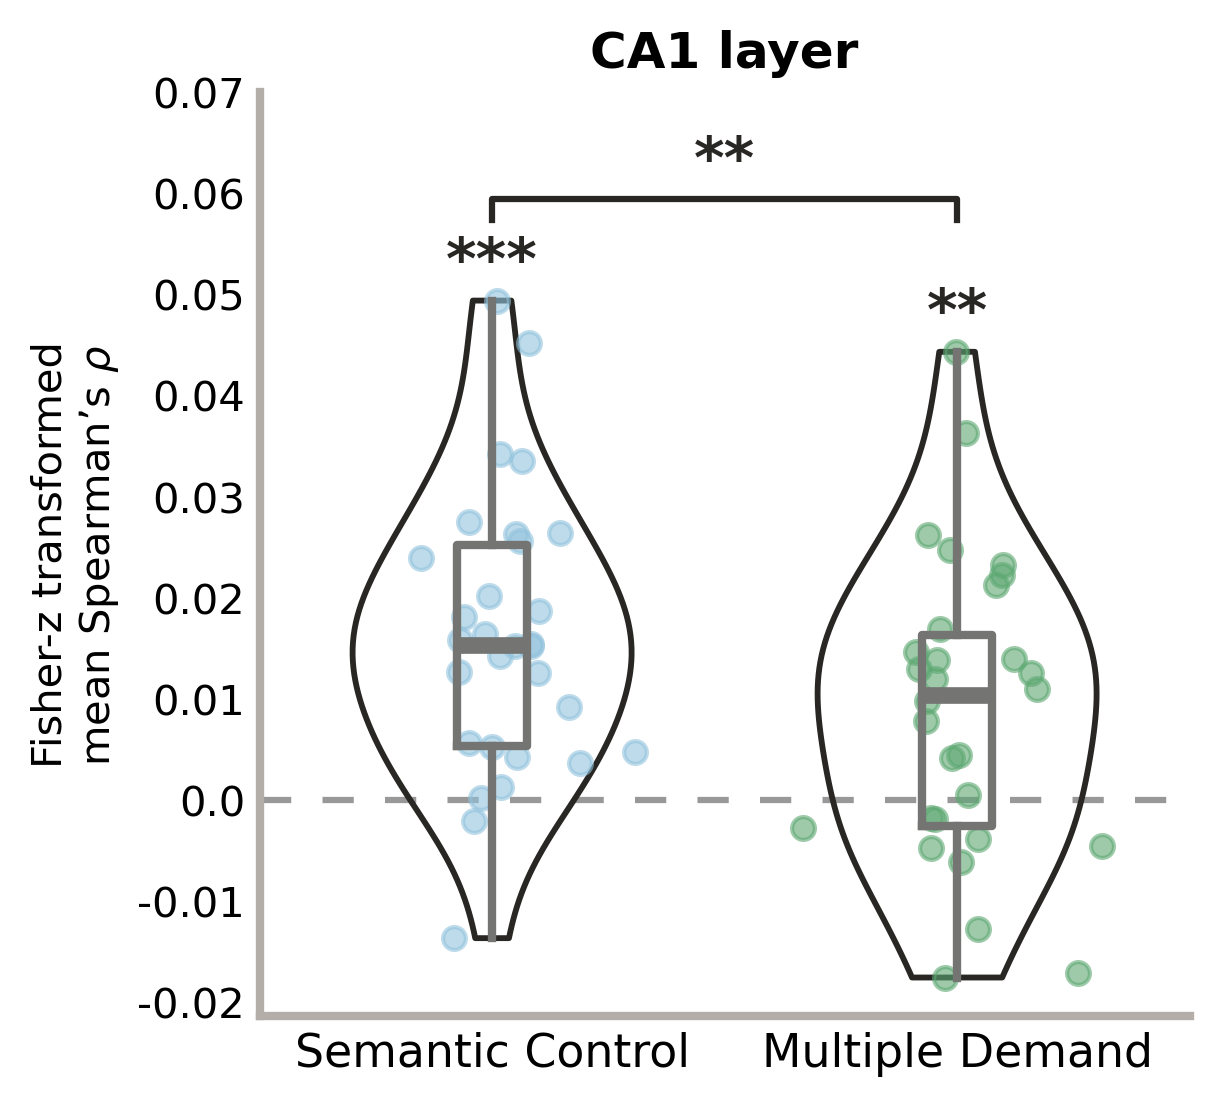

Significance levels legend:
  *** : p < 0.001
  ** : p < 0.01
  * : p < 0.05
  (ns): not significant (p >= 0.05)
--------------------------------------------------
--- One-sample t-tests (mean > 0) ---
Sample 1: t-statistic = 6.4388, p-value = 0.0000***
mean 0.02, std 0.01
  Conclusion: The mean of Sample 1 is significantly greater than 0 (***).
----------------------------------------
Sample 2: t-statistic = 3.2184, p-value = 0.0016**
mean 0.01, std 0.01
  Conclusion: The mean of Sample 2 is significantly greater than 0 (**).

--- Paired t-test (difference between samples) ---
Paired test between Sample 1 and Sample 2 (two-sided):
  T-statistic = 2.8887, p-value = 0.0072**
  Conclusion: There is a significant difference between the means of Sample 1 and Sample 2 (**).


In [102]:
# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [ca1_semantic_corr, ca1_general_corr]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.1
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#92C3DD", "#5DA872"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
HLINES = [-0.02, -0.01, 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]

fig, ax = plt.subplots(figsize= (4, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    if h == 0.0: ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.6,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.6)

max_y0 = max(y_data[0])
max_y1 = max(y_data[1])
offset = 0.001
ax.text(POSITIONS[0], max_y0 + offset, "***", ha='center', va='bottom', weight="bold", fontsize=14, color=BLACK)
ax.text(POSITIONS[1], max_y1 + offset, "**", ha='center', va='bottom', weight="bold", fontsize=14, color=BLACK)


# Add significance line ----------------------------------------------
# Calculate the height for the significance bar
y_max = max(max(y_data[0]), max(y_data[1]))
bar_height = y_max + 0.01 # Adjust offset as needed
tick_height = 0.002       # Height of the small vertical ticks

# Plot the horizontal bar
ax.plot([POSITIONS[0], POSITIONS[0], POSITIONS[1], POSITIONS[1]], 
        [bar_height - tick_height, bar_height, bar_height, bar_height - tick_height], 
        lw=1.5, c=BLACK)

# Add the significance star
ax.text((POSITIONS[0] + POSITIONS[1]) / 2, bar_height + 0.001, "**", ha='center', va='bottom', color=BLACK, fontsize=14, weight="bold")

# You might need to adjust the y-axis limits if the bar goes out of bounds
current_ylim = ax.get_ylim()
ax.set_ylim(current_ylim[0], max(current_ylim[1], bar_height + 0.005)) # Adjust upper limit if needed


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Fisher-z transformed\nmean Spearman’s "r"$\rho$", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["Semantic Control", "Multiple Demand"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")
plt.title("CA1 layer", size=12, weight="bold")

plt.savefig("./B01_figures/outputs/fig_5c_right.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_5c_right.png", format="png", bbox_inches='tight')

plt.show()

# -----------------------------------------------
# Extract the two lists
sample1 = y_data[0]
sample2 = y_data[1]

# --- Helper function to get significance stars ---
def get_significance_stars(p_value):
    """
    Returns significance stars based on p-value.
    ***: p < 0.001
    **:  p < 0.01
    *:   p < 0.05
    """
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "" # No stars if not significant at p < 0.05

# --- Print significance legend ---
print("Significance levels legend:")
print("  *** : p < 0.001")
print("  ** : p < 0.01")
print("  * : p < 0.05")
print("  (ns): not significant (p >= 0.05)")
print("-" * 50)


# --- Test 1: Check if the mean of each sample is significantly greater than zero ---
# We use a one-sample t-test.
# H0: The mean of the sample is equal to 0.
# H1: The mean of the sample is greater than 0.

print("--- One-sample t-tests (mean > 0) ---")
# Primary significance level for conclusion text
alpha = 0.05

# For sample 1
# The 'alternative' parameter is set to 'greater' for a one-sided test.
t_statistic_s1, p_value_s1 = stats.ttest_1samp(sample1, 0, alternative='greater')
stars_s1 = get_significance_stars(p_value_s1)

print(f"Sample 1: t-statistic = {t_statistic_s1:.4f}, p-value = {p_value_s1:.4f}{stars_s1}")
print(f'mean {np.mean(sample1):.2f}, std {np.std(sample1):.2f}')
if p_value_s1 < alpha: # General conclusion based on alpha = 0.05
    print(f"  Conclusion: The mean of Sample 1 is significantly greater than 0 ({stars_s1 if stars_s1 else 'p < 0.05'}).")
else:
    print(f"  Conclusion: There is not enough evidence to say the mean of Sample 1 is significantly greater than 0 (p = {p_value_s1:.4f}, ns).")

print("-" * 40)

# For sample 2
t_statistic_s2, p_value_s2 = stats.ttest_1samp(sample2, 0, alternative='greater')
stars_s2 = get_significance_stars(p_value_s2)

print(f"Sample 2: t-statistic = {t_statistic_s2:.4f}, p-value = {p_value_s2:.4f}{stars_s2}")
print(f'mean {np.mean(sample2):.2f}, std {np.std(sample2):.2f}')
if p_value_s2 < alpha: # General conclusion based on alpha = 0.05
    print(f"  Conclusion: The mean of Sample 2 is significantly greater than 0 ({stars_s2 if stars_s2 else 'p < 0.05'}).")
else:
    print(f"  Conclusion: There is not enough evidence to say the mean of Sample 2 is significantly greater than 0 (p = {p_value_s2:.4f}, ns).")

print("\n" + "--- Paired t-test (difference between samples) ---")
# --- Test 2: Check if there is a significant difference between the two paired samples ---
# We use a related-samples t-test (paired t-test).
# H0: The true mean difference between paired samples is zero.
# H1: The true mean difference between paired samples is not zero (two-sided test).

t_statistic_paired, p_value_paired = stats.ttest_rel(sample1, sample2, alternative='two-sided') # Default is 'two-sided'
stars_paired = get_significance_stars(p_value_paired)

print(f"Paired test between Sample 1 and Sample 2 (two-sided):")
print(f"  T-statistic = {t_statistic_paired:.4f}, p-value = {p_value_paired:.4f}{stars_paired}")
if p_value_paired < alpha: # General conclusion based on alpha = 0.05
    print(f"  Conclusion: There is a significant difference between the means of Sample 1 and Sample 2 ({stars_paired if stars_paired else 'p < 0.05'}).")
else:
    print(f"  Conclusion: There is not enough evidence to say there is a significant difference between the means of Sample 1 and Sample 2 (p = {p_value_paired:.4f}, ns).")

# Fig 6b Concept group pcorr VOTC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


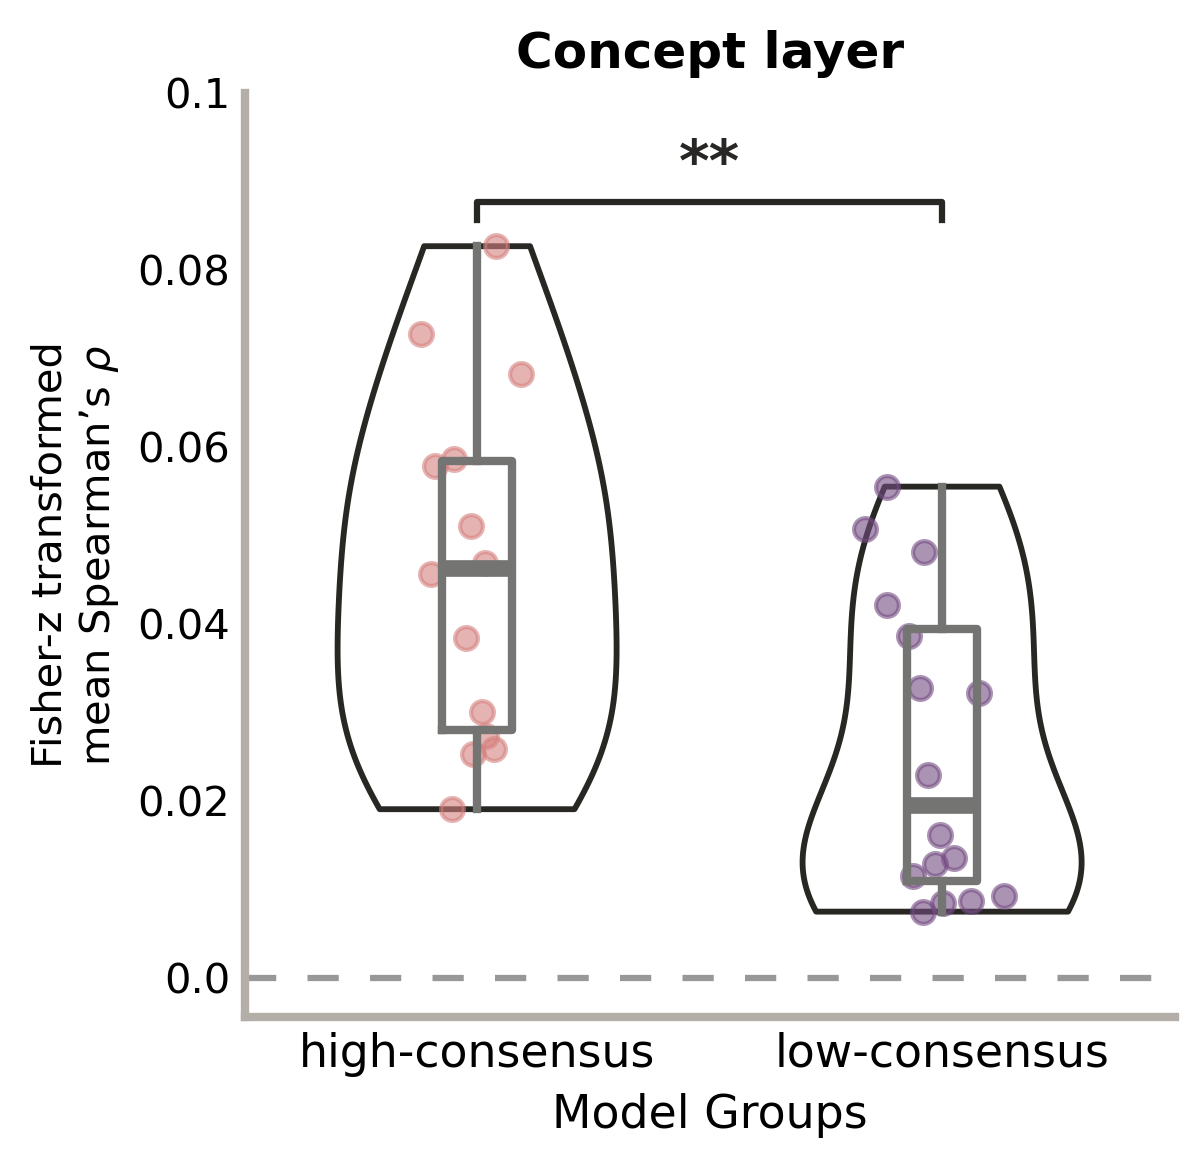

In [103]:
# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [concept_pcorr_interest, concept_pcorr_uninterest]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.07
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#D5817F", purple_hex[5]]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
HLINES = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]

fig, ax = plt.subplots(figsize= (4, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    if h == 0.0: ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.6,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.6)

max_y0 = max(y_data[0])
max_y1 = max(y_data[1])

# Add significance line ----------------------------------------------
# Calculate the height for the significance bar
y_max = max(max(y_data[0]), max(y_data[1]))
bar_height = y_max + 0.005 # Adjust offset as needed
tick_height = 0.002       # Height of the small vertical ticks

# Plot the horizontal bar
ax.plot([POSITIONS[0], POSITIONS[0], POSITIONS[1], POSITIONS[1]], 
        [bar_height - tick_height, bar_height, bar_height, bar_height - tick_height], 
        lw=1.5, c=BLACK)

# Add the significance star
ax.text((POSITIONS[0] + POSITIONS[1]) / 2, bar_height + 0.001, "**", ha='center', va='bottom', color=BLACK, fontsize=14, weight="bold")

# You might need to adjust the y-axis limits if the bar goes out of bounds
current_ylim = ax.get_ylim()
ax.set_ylim(current_ylim[0], max(current_ylim[1], bar_height + 0.005)) # Adjust upper limit if needed


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Fisher-z transformed\nmean Spearman’s "r"$\rho$", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["high-consensus", "low-consensus"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")
ax.set_xlabel("Model Groups", size=11)
plt.title("Concept layer", size=12, weight="bold")

plt.savefig("./B01_figures/outputs/fig_6b.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_6b.png", format="png", bbox_inches='tight')

plt.show()

# Fig S1a Concept pcorr binder rho

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


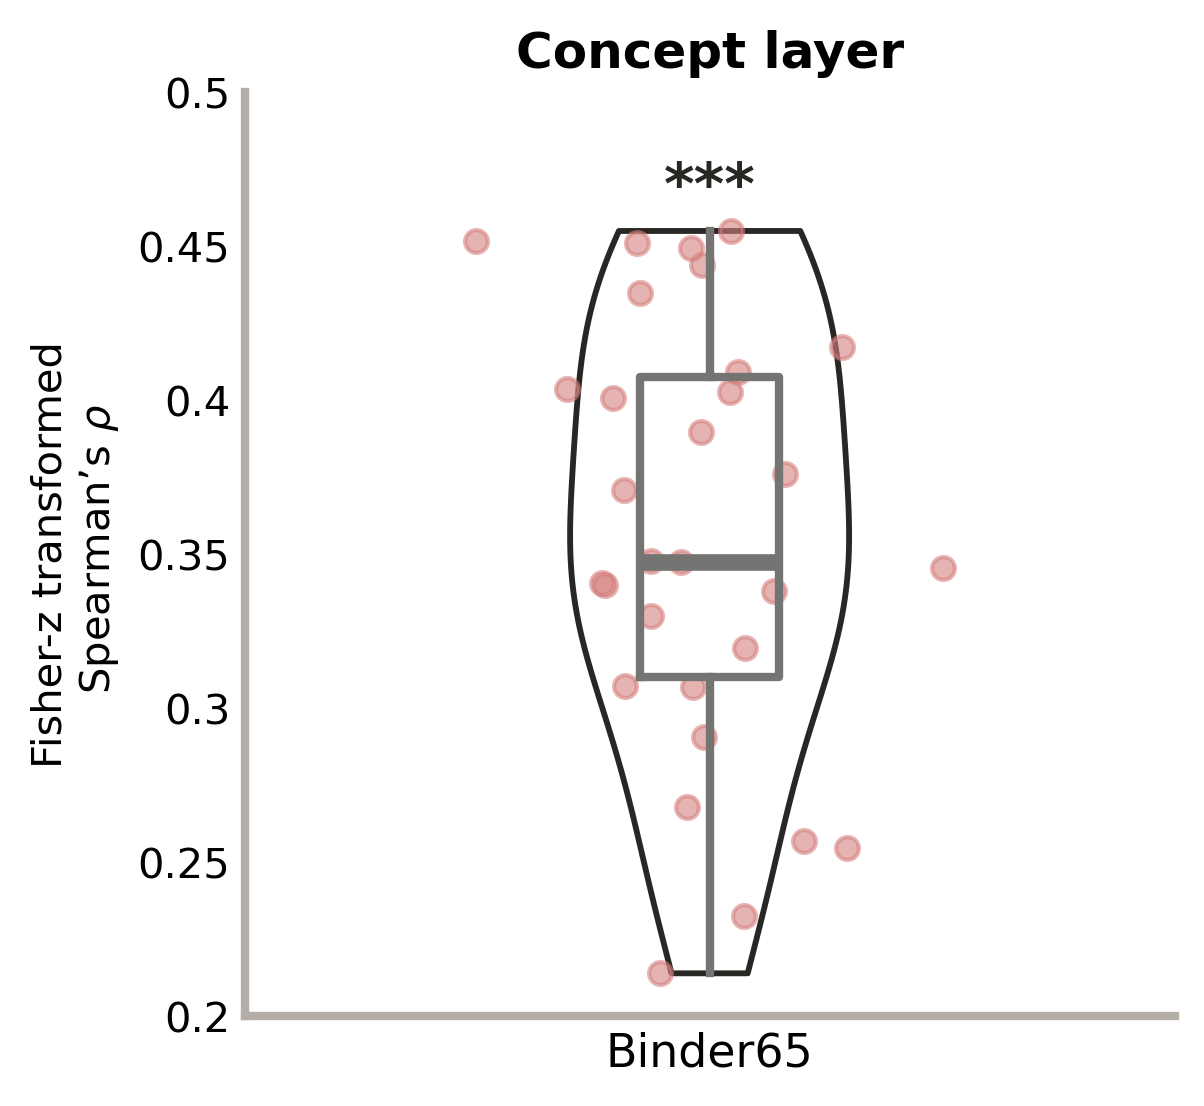

In [104]:
# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [concept_binder_rho]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.07
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#D5817F"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
# HLINES = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
HLINES = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

fig, ax = plt.subplots(figsize= (4, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    if h == 0.0: ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.3,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.6)

max_y = max(y_data[0])
offset = 0.005
ax.text(POSITIONS[0], max_y + offset, "***", ha='center', va='bottom', weight="bold", fontsize=14, color=BLACK)


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Fisher-z transformed\n Spearman’s "r"$\rho$", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["Binder65"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")
plt.title("Concept layer", size=12, weight="bold")

plt.savefig("./B01_figures/outputs/fig_s1a.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_s1a.png", format="png", bbox_inches='tight')

plt.show()

# Fig S1b Concept pcorr binder rho group

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


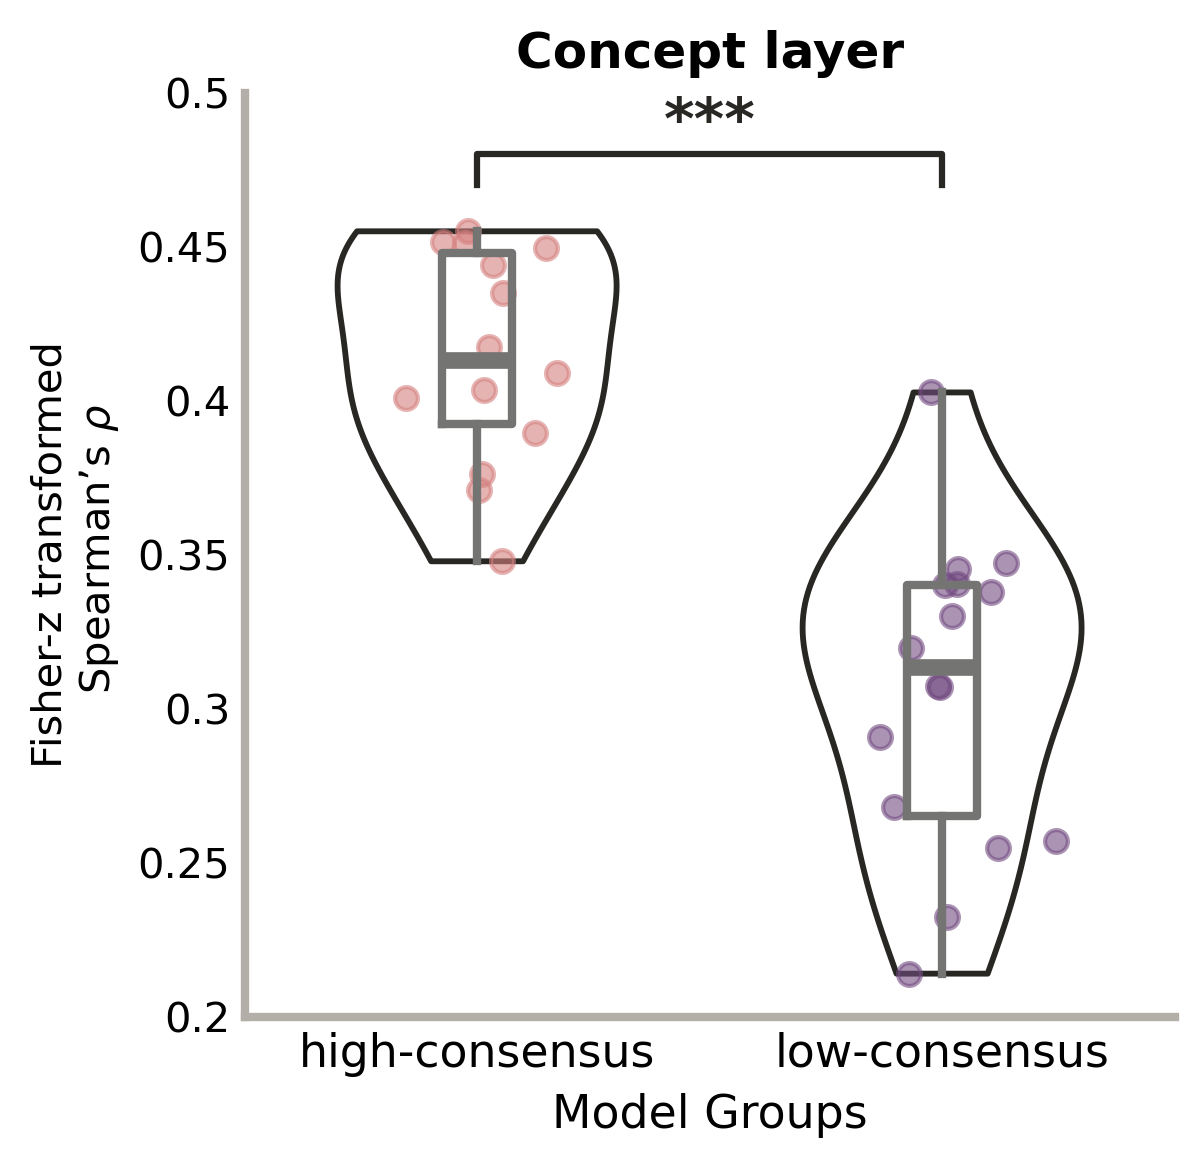

In [105]:
# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [concept_rho_interest, concept_rho_uninterest]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.07
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#D5817F", purple_hex[5]]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
HLINES = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

fig, ax = plt.subplots(figsize= (4, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    if h == 0.0: ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.6,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.6)

max_y0 = max(y_data[0])
max_y1 = max(y_data[1])

# Add significance line ----------------------------------------------
# Calculate the height for the significance bar
y_max = max(max(y_data[0]), max(y_data[1]))
bar_height = y_max + 0.025 # Adjust offset as needed
tick_height = 0.01       # Height of the small vertical ticks

# Plot the horizontal bar
ax.plot([POSITIONS[0], POSITIONS[0], POSITIONS[1], POSITIONS[1]], 
        [bar_height - tick_height, bar_height, bar_height, bar_height - tick_height], 
        lw=1.5, c=BLACK)

# Add the significance star
ax.text((POSITIONS[0] + POSITIONS[1]) / 2, bar_height + 0.001, "***", ha='center', va='bottom', color=BLACK, fontsize=14, weight="bold")

# You might need to adjust the y-axis limits if the bar goes out of bounds
current_ylim = ax.get_ylim()
ax.set_ylim(current_ylim[0], max(current_ylim[1], bar_height + 0.005)) # Adjust upper limit if needed


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Fisher-z transformed\n Spearman’s "r"$\rho$", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["high-consensus", "low-consensus"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")
ax.set_xlabel("Model Groups", size=11)
plt.title("Concept layer", size=12, weight="bold")

plt.savefig("./B01_figures/outputs/fig_s1b.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_s1b.png", format="png", bbox_inches='tight')

plt.show()

# Fig S2a CA2 pcorr semantic vs. general

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


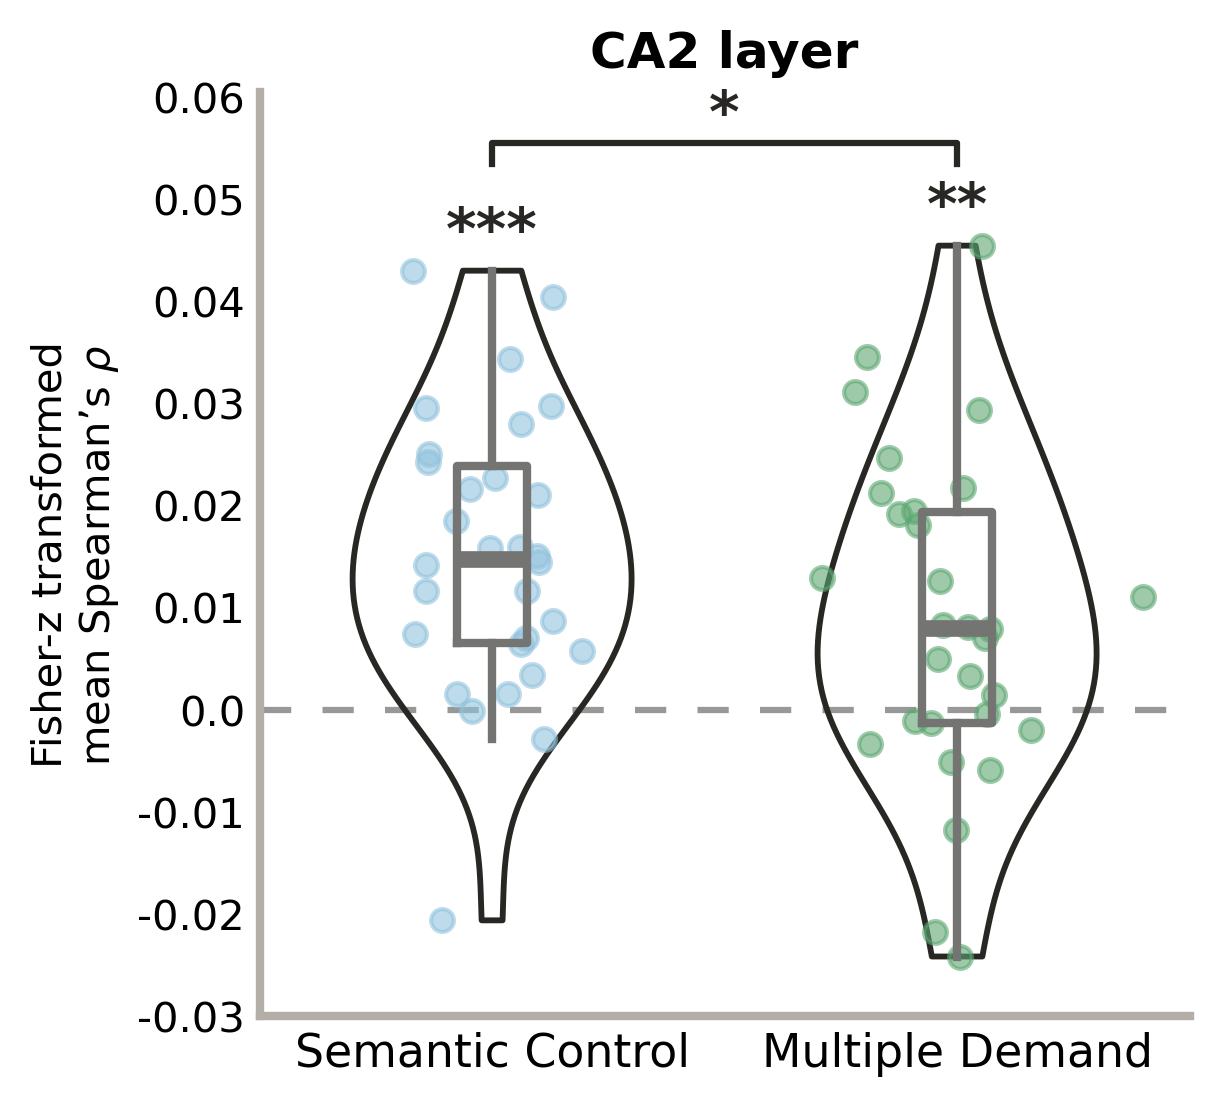

Significance levels legend:
  *** : p < 0.001
  ** : p < 0.01
  * : p < 0.05
  (ns): not significant (p >= 0.05)
--------------------------------------------------
--- One-sample t-tests (mean > 0) ---
Sample 1: t-statistic = 6.0919, p-value = 0.0000***
mean 0.02, std 0.01
  Conclusion: The mean of Sample 1 is significantly greater than 0 (***).
----------------------------------------
Sample 2: t-statistic = 3.0509, p-value = 0.0024**
mean 0.01, std 0.02
  Conclusion: The mean of Sample 2 is significantly greater than 0 (**).

--- Paired t-test (difference between samples) ---
Paired test between Sample 1 and Sample 2 (two-sided):
  T-statistic = 2.3055, p-value = 0.0285*
  Conclusion: There is a significant difference between the means of Sample 1 and Sample 2 (*).


In [106]:
# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [ca2_semantic_corr, ca2_general_corr]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.1
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#92C3DD", "#5DA872"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
HLINES = [-0.03, -0.02, -0.01, 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]

fig, ax = plt.subplots(figsize= (4, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    if h == 0.0: ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.6,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.6)

max_y0 = max(y_data[0])
max_y1 = max(y_data[1])
offset = 0.001
ax.text(POSITIONS[0], max_y0 + offset, "***", ha='center', va='bottom', weight="bold", fontsize=14, color=BLACK)
ax.text(POSITIONS[1], max_y1 + offset, "**", ha='center', va='bottom', weight="bold", fontsize=14, color=BLACK)


# Add significance line ----------------------------------------------
# Calculate the height for the significance bar
y_max = max(max(y_data[0]), max(y_data[1]))
bar_height = y_max + 0.01 # Adjust offset as needed
tick_height = 0.002       # Height of the small vertical ticks

# Plot the horizontal bar
ax.plot([POSITIONS[0], POSITIONS[0], POSITIONS[1], POSITIONS[1]], 
        [bar_height - tick_height, bar_height, bar_height, bar_height - tick_height], 
        lw=1.5, c=BLACK)

# Add the significance star
ax.text((POSITIONS[0] + POSITIONS[1]) / 2, bar_height, "*", ha='center', va='bottom', color=BLACK, fontsize=14, weight="bold")

# You might need to adjust the y-axis limits if the bar goes out of bounds
current_ylim = ax.get_ylim()
ax.set_ylim(current_ylim[0], max(current_ylim[1], bar_height + 0.005)) # Adjust upper limit if needed


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Fisher-z transformed\nmean Spearman’s "r"$\rho$", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["Semantic Control", "Multiple Demand"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")
plt.title("CA2 layer", size=12, weight="bold")

plt.savefig("./B01_figures/outputs/fig_s2a.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_s2a.png", format="png", bbox_inches='tight')

plt.show()

# -----------------------------------------------
# Extract the two lists
sample1 = y_data[0]
sample2 = y_data[1]

# --- Helper function to get significance stars ---
def get_significance_stars(p_value):
    """
    Returns significance stars based on p-value.
    ***: p < 0.001
    **:  p < 0.01
    *:   p < 0.05
    """
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "" # No stars if not significant at p < 0.05

# --- Print significance legend ---
print("Significance levels legend:")
print("  *** : p < 0.001")
print("  ** : p < 0.01")
print("  * : p < 0.05")
print("  (ns): not significant (p >= 0.05)")
print("-" * 50)


# --- Test 1: Check if the mean of each sample is significantly greater than zero ---
# We use a one-sample t-test.
# H0: The mean of the sample is equal to 0.
# H1: The mean of the sample is greater than 0.

print("--- One-sample t-tests (mean > 0) ---")
# Primary significance level for conclusion text
alpha = 0.05

# For sample 1
# The 'alternative' parameter is set to 'greater' for a one-sided test.
t_statistic_s1, p_value_s1 = stats.ttest_1samp(sample1, 0, alternative='greater')
stars_s1 = get_significance_stars(p_value_s1)

print(f"Sample 1: t-statistic = {t_statistic_s1:.4f}, p-value = {p_value_s1:.4f}{stars_s1}")
print(f'mean {np.mean(sample1):.2f}, std {np.std(sample1):.2f}')
if p_value_s1 < alpha: # General conclusion based on alpha = 0.05
    print(f"  Conclusion: The mean of Sample 1 is significantly greater than 0 ({stars_s1 if stars_s1 else 'p < 0.05'}).")
else:
    print(f"  Conclusion: There is not enough evidence to say the mean of Sample 1 is significantly greater than 0 (p = {p_value_s1:.4f}, ns).")

print("-" * 40)

# For sample 2
t_statistic_s2, p_value_s2 = stats.ttest_1samp(sample2, 0, alternative='greater')
stars_s2 = get_significance_stars(p_value_s2)

print(f"Sample 2: t-statistic = {t_statistic_s2:.4f}, p-value = {p_value_s2:.4f}{stars_s2}")
print(f'mean {np.mean(sample2):.2f}, std {np.std(sample2):.2f}')
if p_value_s2 < alpha: # General conclusion based on alpha = 0.05
    print(f"  Conclusion: The mean of Sample 2 is significantly greater than 0 ({stars_s2 if stars_s2 else 'p < 0.05'}).")
else:
    print(f"  Conclusion: There is not enough evidence to say the mean of Sample 2 is significantly greater than 0 (p = {p_value_s2:.4f}, ns).")

print("\n" + "--- Paired t-test (difference between samples) ---")
# --- Test 2: Check if there is a significant difference between the two paired samples ---
# We use a related-samples t-test (paired t-test).
# H0: The true mean difference between paired samples is zero.
# H1: The true mean difference between paired samples is not zero (two-sided test).

t_statistic_paired, p_value_paired = stats.ttest_rel(sample1, sample2, alternative='two-sided') # Default is 'two-sided'
stars_paired = get_significance_stars(p_value_paired)

print(f"Paired test between Sample 1 and Sample 2 (two-sided):")
print(f"  T-statistic = {t_statistic_paired:.4f}, p-value = {p_value_paired:.4f}{stars_paired}")
if p_value_paired < alpha: # General conclusion based on alpha = 0.05
    print(f"  Conclusion: There is a significant difference between the means of Sample 1 and Sample 2 ({stars_paired if stars_paired else 'p < 0.05'}).")
else:
    print(f"  Conclusion: There is not enough evidence to say there is a significant difference between the means of Sample 1 and Sample 2 (p = {p_value_paired:.4f}, ns).")

# Fig S2b CA3 pcorr semantic vs. generate

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


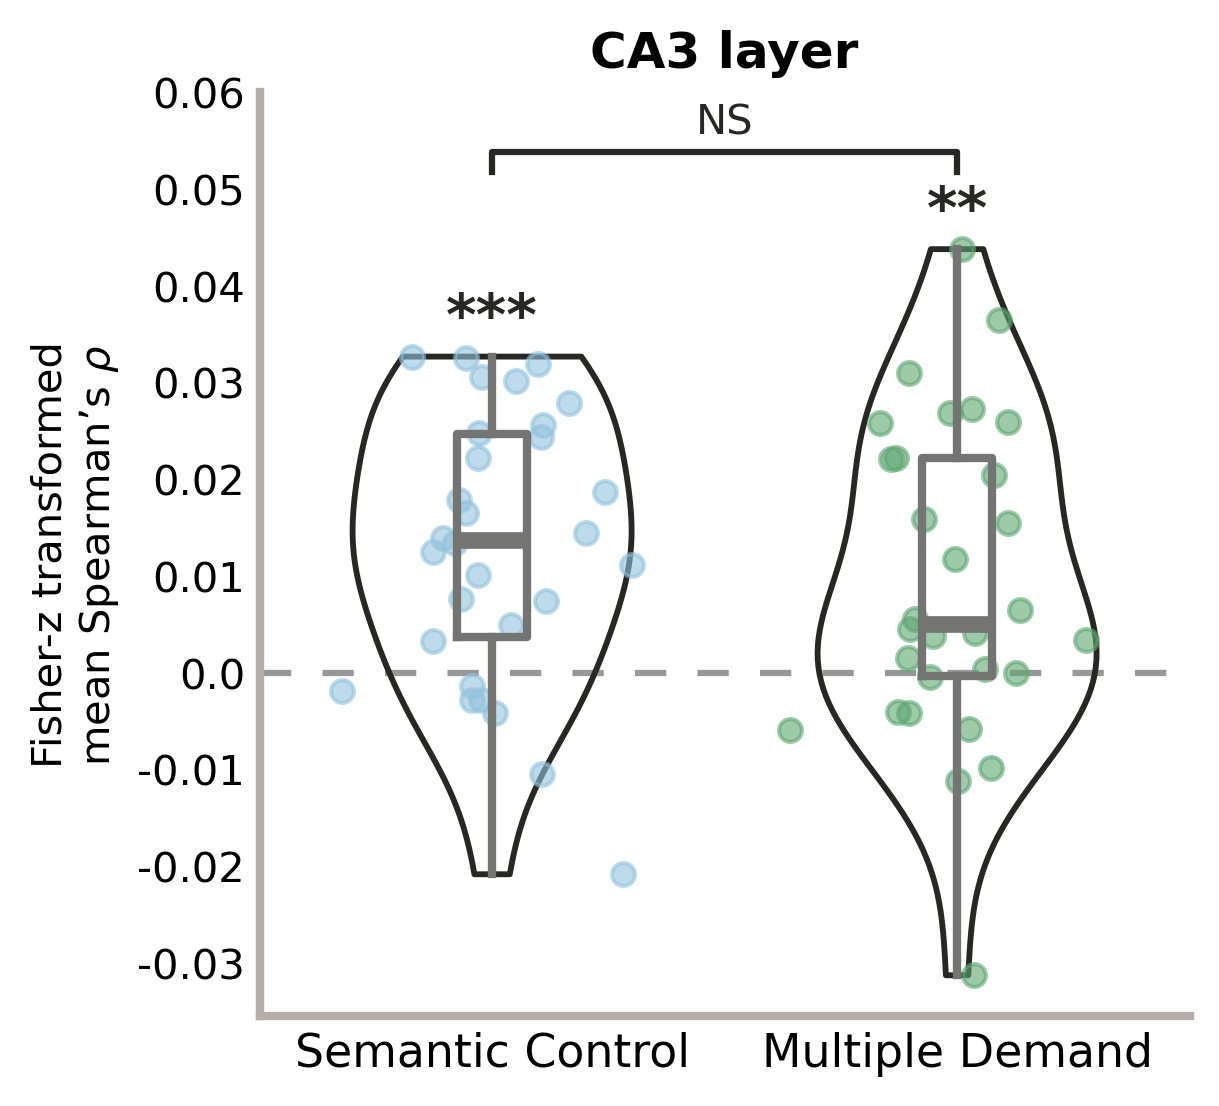

Significance levels legend:
  *** : p < 0.001
  ** : p < 0.01
  * : p < 0.05
  (ns): not significant (p >= 0.05)
--------------------------------------------------
--- One-sample t-tests (mean > 0) ---
Sample 1: t-statistic = 5.0907, p-value = 0.0000***
mean 0.01, std 0.01
  Conclusion: The mean of Sample 1 is significantly greater than 0 (***).
----------------------------------------
Sample 2: t-statistic = 3.1418, p-value = 0.0019**
mean 0.01, std 0.02
  Conclusion: The mean of Sample 2 is significantly greater than 0 (**).

--- Paired t-test (difference between samples) ---
Paired test between Sample 1 and Sample 2 (two-sided):
  T-statistic = 1.3300, p-value = 0.1939
  Conclusion: There is not enough evidence to say there is a significant difference between the means of Sample 1 and Sample 2 (p = 0.1939, ns).


In [108]:
# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [ca3_semantic_corr, ca3_general_corr]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.1
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#92C3DD", "#5DA872"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
HLINES = [-0.03, -0.02, -0.01, 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]

fig, ax = plt.subplots(figsize= (4, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    if h == 0.0: ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.6,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.6)

max_y0 = max(y_data[0])
max_y1 = max(y_data[1])
offset = 0.001
ax.text(POSITIONS[0], max_y0 + offset, "***", ha='center', va='bottom', weight="bold", fontsize=14, color=BLACK)
ax.text(POSITIONS[1], max_y1 + offset, "**", ha='center', va='bottom', weight="bold", fontsize=14, color=BLACK)


# Add significance line ----------------------------------------------
# Calculate the height for the significance bar
y_max = max(max(y_data[0]), max(y_data[1]))
bar_height = y_max + 0.01 # Adjust offset as needed
tick_height = 0.002       # Height of the small vertical ticks

# Plot the horizontal bar
ax.plot([POSITIONS[0], POSITIONS[0], POSITIONS[1], POSITIONS[1]], 
        [bar_height - tick_height, bar_height, bar_height, bar_height - tick_height], 
        lw=1.5, c=BLACK)

# Add the significance star
ax.text((POSITIONS[0] + POSITIONS[1]) / 2, bar_height + 0.001, "NS", ha='center', va='bottom', color=BLACK, fontsize=10)

# You might need to adjust the y-axis limits if the bar goes out of bounds
current_ylim = ax.get_ylim()
ax.set_ylim(current_ylim[0], max(current_ylim[1], bar_height + 0.005)) # Adjust upper limit if needed


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Fisher-z transformed\nmean Spearman’s "r"$\rho$", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["Semantic Control", "Multiple Demand"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")
plt.title("CA3 layer", size=12, weight="bold")

plt.savefig("./B01_figures/outputs/fig_s2b.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_s2b.png", format="png", bbox_inches='tight')

plt.show()

# -----------------------------------------------
# Extract the two lists
sample1 = y_data[0]
sample2 = y_data[1]

# --- Helper function to get significance stars ---
def get_significance_stars(p_value):
    """
    Returns significance stars based on p-value.
    ***: p < 0.001
    **:  p < 0.01
    *:   p < 0.05
    """
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "" # No stars if not significant at p < 0.05

# --- Print significance legend ---
print("Significance levels legend:")
print("  *** : p < 0.001")
print("  ** : p < 0.01")
print("  * : p < 0.05")
print("  (ns): not significant (p >= 0.05)")
print("-" * 50)


# --- Test 1: Check if the mean of each sample is significantly greater than zero ---
# We use a one-sample t-test.
# H0: The mean of the sample is equal to 0.
# H1: The mean of the sample is greater than 0.

print("--- One-sample t-tests (mean > 0) ---")
# Primary significance level for conclusion text
alpha = 0.05

# For sample 1
# The 'alternative' parameter is set to 'greater' for a one-sided test.
t_statistic_s1, p_value_s1 = stats.ttest_1samp(sample1, 0, alternative='greater')
stars_s1 = get_significance_stars(p_value_s1)

print(f"Sample 1: t-statistic = {t_statistic_s1:.4f}, p-value = {p_value_s1:.4f}{stars_s1}")
print(f'mean {np.mean(sample1):.2f}, std {np.std(sample1):.2f}')
if p_value_s1 < alpha: # General conclusion based on alpha = 0.05
    print(f"  Conclusion: The mean of Sample 1 is significantly greater than 0 ({stars_s1 if stars_s1 else 'p < 0.05'}).")
else:
    print(f"  Conclusion: There is not enough evidence to say the mean of Sample 1 is significantly greater than 0 (p = {p_value_s1:.4f}, ns).")

print("-" * 40)

# For sample 2
t_statistic_s2, p_value_s2 = stats.ttest_1samp(sample2, 0, alternative='greater')
stars_s2 = get_significance_stars(p_value_s2)

print(f"Sample 2: t-statistic = {t_statistic_s2:.4f}, p-value = {p_value_s2:.4f}{stars_s2}")
print(f'mean {np.mean(sample2):.2f}, std {np.std(sample2):.2f}')
if p_value_s2 < alpha: # General conclusion based on alpha = 0.05
    print(f"  Conclusion: The mean of Sample 2 is significantly greater than 0 ({stars_s2 if stars_s2 else 'p < 0.05'}).")
else:
    print(f"  Conclusion: There is not enough evidence to say the mean of Sample 2 is significantly greater than 0 (p = {p_value_s2:.4f}, ns).")

print("\n" + "--- Paired t-test (difference between samples) ---")
# --- Test 2: Check if there is a significant difference between the two paired samples ---
# We use a related-samples t-test (paired t-test).
# H0: The true mean difference between paired samples is zero.
# H1: The true mean difference between paired samples is not zero (two-sided test).

t_statistic_paired, p_value_paired = stats.ttest_rel(sample1, sample2, alternative='two-sided') # Default is 'two-sided'
stars_paired = get_significance_stars(p_value_paired)

print(f"Paired test between Sample 1 and Sample 2 (two-sided):")
print(f"  T-statistic = {t_statistic_paired:.4f}, p-value = {p_value_paired:.4f}{stars_paired}")
if p_value_paired < alpha: # General conclusion based on alpha = 0.05
    print(f"  Conclusion: There is a significant difference between the means of Sample 1 and Sample 2 ({stars_paired if stars_paired else 'p < 0.05'}).")
else:
    print(f"  Conclusion: There is not enough evidence to say there is a significant difference between the means of Sample 1 and Sample 2 (p = {p_value_paired:.4f}, ns).")

# Fig S3 Concept pcorr binder subdomain rho

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


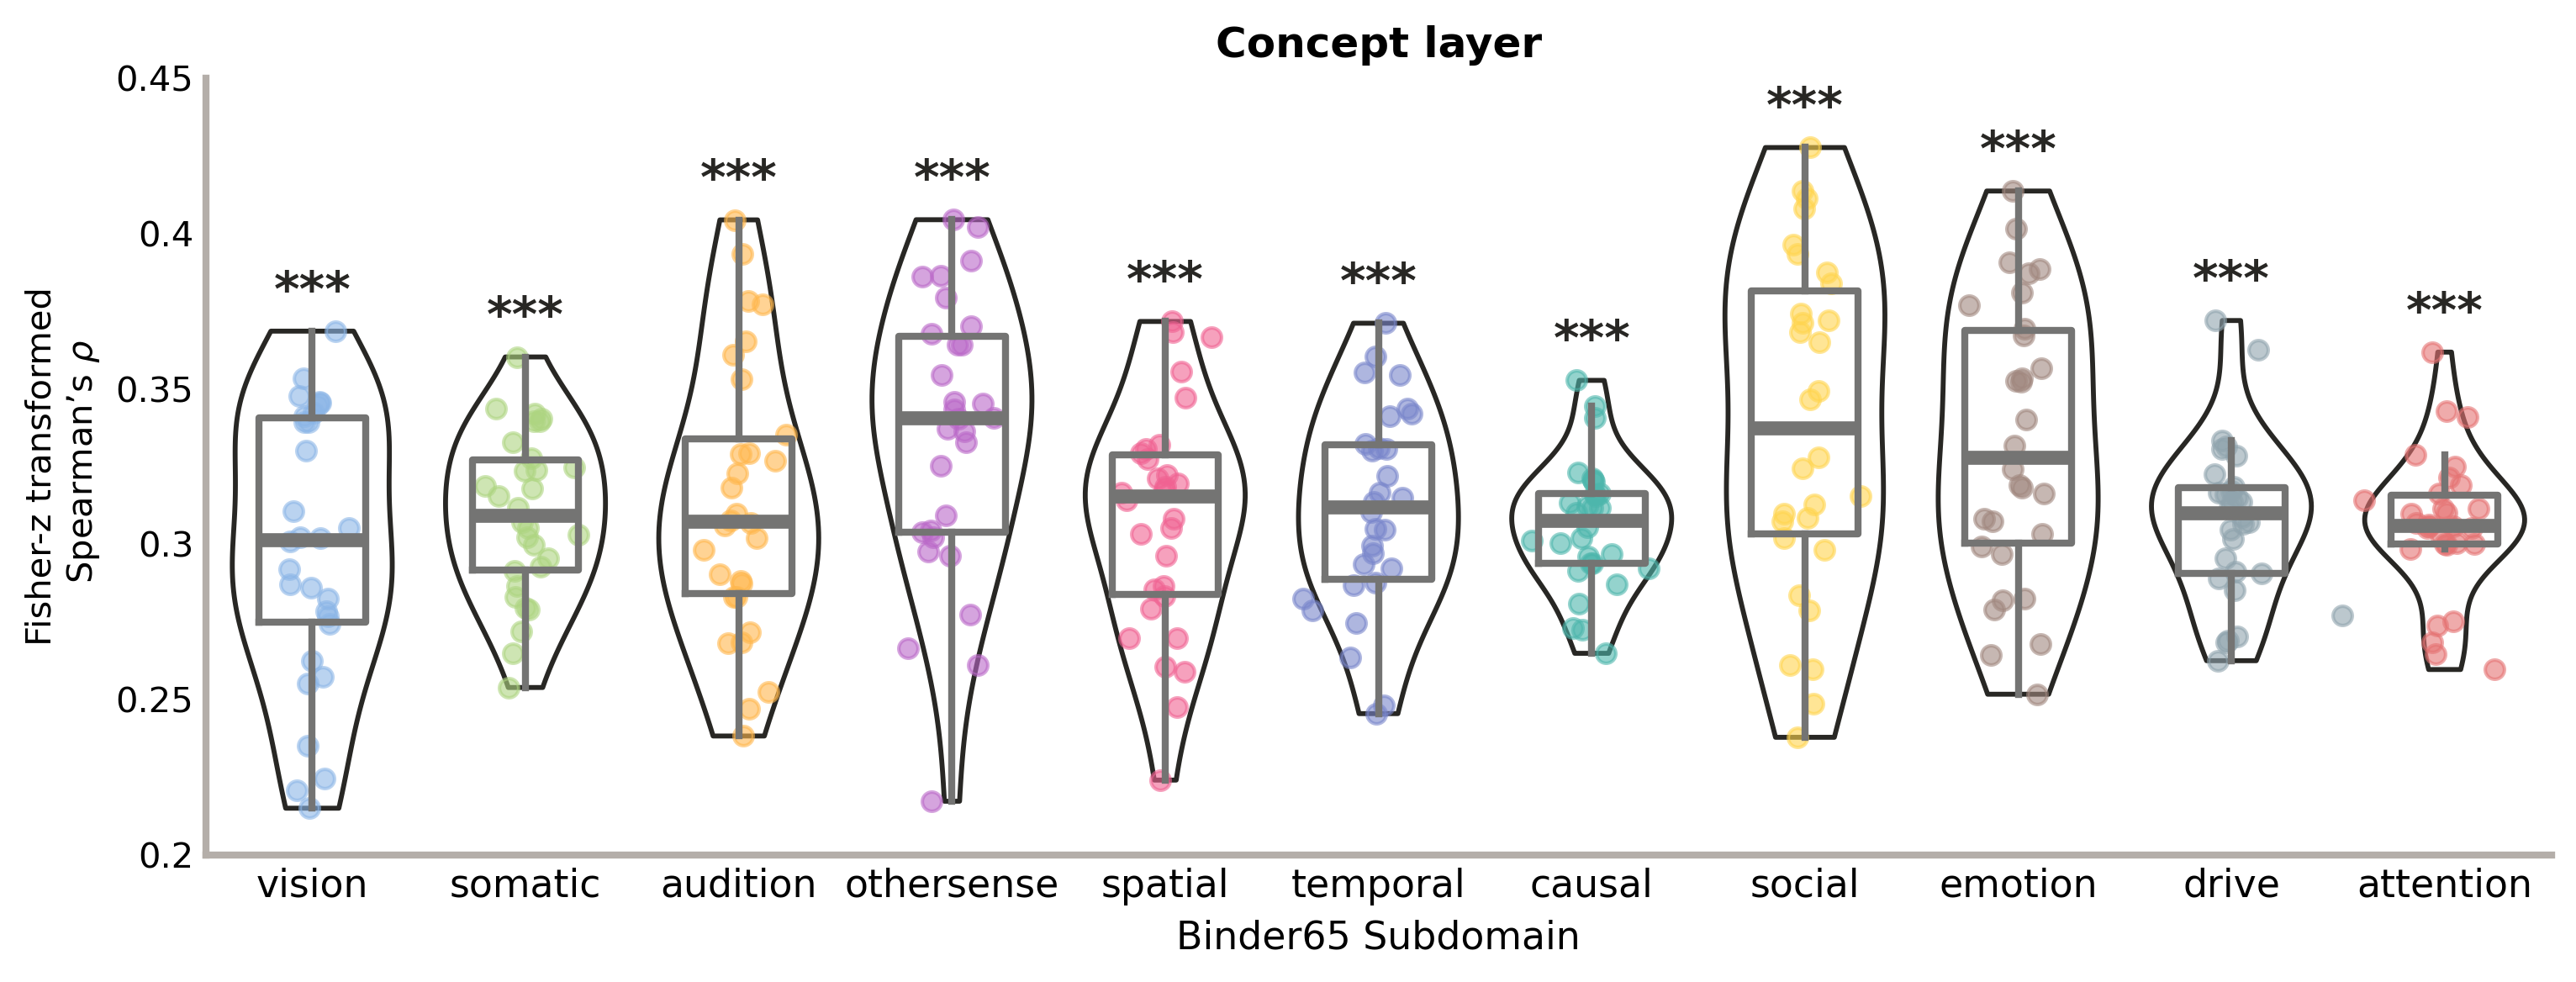

In [109]:
# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = concept_bindersub_rho

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.07
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = [
    "#8CB6E7",  # Light Blue
    "#AED581",  # Light Green
    "#FFB74D",  # Light Orange
    "#BA68C8",  # Light Purple
    "#F06292",  # Pink
    "#7986CB",  # Indigo
    "#4DB6AC",  # Teal
    "#FFD54F",  # Amber
    "#A1887F",  # Brown
    "#90A4AE",  # Blue Grey
    "#E57373"   # Light Red
]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [i for i, d in enumerate(y_data)]

# Horizontal lines
# HLINES = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
HLINES = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45]

fig, ax = plt.subplots(figsize= (12, 4), dpi=300)

# Some layout stuff ----------------------------------------------
# # Background color
# fig.patch.set_facecolor(BG_WHITE)
# ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    if h == 0.0: ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.75,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 30, color=color, alpha=0.6)

for idx in range(len(y_data)):
    max_y = max(y_data[idx])
    offset = 0.005
    ax.text(POSITIONS[idx], max_y + offset, "***", ha='center', va='bottom', weight="bold", fontsize=14, color=BLACK)


# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=10)
ax.set_ylabel("Fisher-z transformed\n Spearman’s "r"$\rho$", size=10)

# xlabels accounts for the sample size for each species
xlabels = ["vision", "somatic", "audition", "othersense", "spatial", "temporal", "causal", "social", "emotion", "drive", "attention"]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=11, ha="center", ma="center")
ax.set_xlabel("Binder65 Subdomain", size=11)
plt.title("Concept layer", size=12, weight="bold")

plt.savefig("./B01_figures/outputs/fig_s3.eps", format="eps", bbox_inches='tight')
plt.savefig("./B01_figures/outputs/fig_s3.png", format="png", bbox_inches='tight')

plt.show()

# Examples Marginal plot 
https://python-graph-gallery.com/82-marginal-plot-with-seaborn/

In [ ]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
df = sns.load_dataset('iris')
 
# Custom the histogram:
sns.jointplot(x=df["sepal_length"], y=df["sepal_width"], kind='hex', marginal_kws=dict(bins=30, fill=True))

plt.show()

# Examples ridgeline plot
https://python-graph-gallery.com/web-ridgeline-by-text/

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
rent_path = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/rent.csv'
rent = pd.read_csv(rent_path)

rent_words_path = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/rent_title_words.csv'
rent_words = pd.read_csv(rent_words_path)

df_path = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/df_plot.csv'
df = pd.read_csv(df_path)

ngroups = df['word'].nunique()    # Dynamically calculate the number of rows in the chart.

bandwidth = 1                     # Control how smooth you want the graphs

In [ ]:
darkgreen = '#9BC184'
midgreen = '#C2D6A4'
lowgreen = '#E7E5CB'
colors = [lowgreen, midgreen, darkgreen, midgreen, lowgreen]

darkgrey = '#525252'

fig, axs = plt.subplots(nrows=15, ncols=1, figsize=(8, 10))
axs = axs.flatten() # needed to access each individual axis

# iterate over axes
words = df.sort_values('mean_price')['word'].unique().tolist()
for i, word in enumerate(words):

    # subset the data for each word
    subset = df[df['word'] == word]

    # plot the distribution of prices
    sns.kdeplot(
        subset['price'],
        fill=True,
        ax=axs[i],
        color='grey',
        edgecolor='lightgrey'
    )

    # global mean reference line
    global_mean = rent['price'].mean()
    axs[i].axvline(global_mean, color=darkgrey, linestyle='--')

    # display average number of bedrooms on left
    rent_with_bed = rent_words[rent_words['beds'] > 0]
    rent_with_bed_filter = rent_with_bed[rent_with_bed['word'] == word]
    avg_bedrooms = rent_with_bed_filter['beds'].mean().round(1)
    axs[i].text(
        -600, 0,
        f'({avg_bedrooms})',
        ha='left',
        fontsize=10,
        color=darkgrey
    )

    # display word on left
    axs[i].text(
        -2000, 0,
        word.upper(),
        ha='left',
        fontsize=10,
        color=darkgrey
    )

    # compute quantiles
    quantiles = np.percentile(subset['price'], [2.5, 10, 25, 75, 90, 97.5])
    quantiles = quantiles.tolist()

    # fill space between each pair of quantiles
    for j in range(len(quantiles) - 1):
        axs[i].fill_between(
            [quantiles[j], # lower bound
             quantiles[j+1]], # upper bound
            0, # max y=0
            0.0002, # max y=0.0002
            color=colors[j]
        )

    # mean value as a reference
    mean = subset['price'].mean()
    axs[i].scatter([mean], [0.0001], color='black', s=10)

    # set title and labels
    axs[i].set_xlim(0, 10000)
    axs[i].set_ylim(0, 0.001)
    axs[i].set_ylabel('')

    # x axis scale for last ax
    if i == 14:
        values = [2500, 5000, 7500, 10000]
        for value in values:
            axs[i].text(
                value, -0.0005,
                f'{value}',
                ha='center',
                fontsize=10
            )

    # remove axis
    axs[i].set_axis_off()

text = 'Mean rent'
fig.text(
    0.35, 0.88,
    text,
    ha='center',
    fontsize=10
)

# credit
text = """
Axis capped at 10,000 USD.
Data: Pennington, Kate (2018).
Bay Area Craigslist Rental Housing Posts, 2000-2018.
Retrieved from github.com/katepennington/historic_bay_area_craigslist_housing_posts/blob/master/clean_2000_2018.csv.zip.
Visualization: Ansgar Wolsing
"""
fig.text(
    -0.03, -0.05,
    text,
    ha='left',
    fontsize=8,
)

# x axis label
text = "Rent in USD"
fig.text(
    0.5, 0.06,
    text,
    ha='center',
    fontsize=14,
)

# description
text = """
Adjectives used to describe houses and apartments in the San Francisco Bay Area in the titles of rental
posts on Craigslist and how they are related to rental prices. Titles from 198,279 rental posts on Craigslist
between 2000 and 2018. The 15 most frequent adjectives are shown.
"""
fig.text(
    -0.03, 0.9,
    text,
    ha='left',
    fontsize=12,
)

# title
text = "NICE AND CLEAN - RELATIVELY LOW RENT?"
fig.text(
    -0.03, 1.01,
    text,
    ha='left',
    fontsize=18,
)

# number of bedrooms label
text = '(Ø bedrooms)'
fig.text(
    0.04, 0.88,
    text,
    ha='left',
    fontsize=10,
    color=darkgrey
)

# legend on the first ax
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
subax = inset_axes(
    parent_axes=axs[0],
    width="40%",
    height="350%",
    loc=1
)
subax.set_xticks([])
subax.set_yticks([])
beautiful_subset = df[df['word'] == 'beautiful']
sns.kdeplot(
    beautiful_subset['price'],
    fill=True,
    ax=subax,
    color='grey',
    edgecolor='lightgrey'
)
quantiles = np.percentile(beautiful_subset['price'], [2.5, 10, 25, 75, 90, 97.5])
quantiles = quantiles.tolist()
for j in range(len(quantiles) - 1):
    subax.fill_between(
        [quantiles[j], # lower bound
         quantiles[j+1]], # upper bound
        0, # max y=0
        0.00004, # max y=0.00004
        color=colors[j]
    )
subax.set_xlim(-500, 7000)
subax.set_ylim(-0.0002, 0.0006)
mean = beautiful_subset['price'].mean()
subax.scatter([mean], [0.00002], color='black', s=10)
subax.text(
    -300, 0.0005,
    'Legend',
    ha='left',
    fontsize=12,
)
subax.text(
    4800, 0.00025,
    'Distribution\nof prices',
    ha='center',
    fontsize=7,
)
subax.text(
    mean+400, 0.00015,
    'Mean',
    ha='center',
    fontsize=7,
)
subax.text(
    5500, -0.00015,
    "95% of prices",
    ha='center',
    fontsize=6,
)
subax.text(
    3500, -0.00015,
    "80% of prices",
    ha='center',
    fontsize=6,
)
subax.text(
    1200, -0.00018,
    "50% of prices\nfall within this range",
    ha='center',
    fontsize=6,
)

# arrows in the legend
import matplotlib.patches as patches
def add_arrow(head_pos, tail_pos, ax):
    style = "Simple, tail_width=0.01, head_width=1, head_length=2"
    kw = dict(arrowstyle=style, color="k", linewidth=0.2)
    arrow = patches.FancyArrowPatch(
        tail_pos, head_pos,
        connectionstyle="arc3,rad=.5",
        **kw
    )
    ax.add_patch(arrow)
add_arrow((mean, 0.00005), (mean+200, 0.00013), subax) # mean
add_arrow((mean+1000, 0), (mean+1200, -0.00011), subax) # 80%
add_arrow((mean+2400, 0), (mean+2600, -0.00011), subax) # 95%
add_arrow((mean-500, 0), (mean-800, -0.00009), subax) # 50%

# background grey lines
from matplotlib.lines import Line2D
def add_line(xpos, ypos, fig=fig):
    line = Line2D(
        xpos, ypos,
        color='lightgrey',
        lw=0.2,
        transform=fig.transFigure
    )
    fig.lines.append(line)
add_line([0.317, 0.317], [0.1, 0.9])
add_line([0.51, 0.51], [0.1, 0.9])
add_line([0.703, 0.703], [0.1, 0.9])
add_line([0.896, 0.896], [0.1, 0.9])

plt.show()

# Examples Violin plot 
https://python-graph-gallery.com/web-ggbetweenstats-with-matplotlib/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

from palmerpenguins import load_penguins

penguins = load_penguins()
print(penguins.head())

print(type(penguins))
penguins = penguins.dropna()

# Get the species, sorted alphabetically
species = sorted(penguins["species"].unique())

# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [penguins[penguins["species"] == specie]["bill_length_mm"].values for specie in species]
# y_data = [acc_list_imagenet1k_ss20_fixfe_trail50, acc_list_random_imagenet1k_ss20_fixfe_trail50]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [0, 1, 2]

# Horizontal lines
HLINES = [40, 50, 60]

fig, ax = plt.subplots(figsize= (14, 10))

# Some layout stuff ----------------------------------------------
# Background color
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 100, color=color, alpha=0.4)

# Add mean value labels ------------------------------------------
means = [y.mean() for y in y_data]
for i, mean in enumerate(means):
    # Add dot representing the mean
    ax.scatter(i, mean, s=250, color=RED_DARK, zorder=3)
    
    # Add line conecting mean value and its label
    ax.plot([i, i + 0.25], [mean, mean], ls="dashdot", color="black", zorder=3)
    
    # Add mean value label.
    ax.text(
        i + 0.25,
        mean,
        r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 2)),
        fontsize=13,
        va="center",
        bbox = dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round",
            pad=0.15
        ),
        zorder=10 # to make sure the line is on top
    )

# Add multiple comparisons p-value for mean difference -----------
# Plot lines indicating what means are compared
# 'tick_len' gives the length of the tick on the end of each line

tick_len = 0.25
ax.plot([0, 0, 1, 1], [62.5 - tick_len, 62.5, 62.5, 62.5 - tick_len], c="black")
ax.plot([0, 0, 2, 2], [65 - tick_len, 65, 65, 65 - tick_len], c="black")
ax.plot([1, 1, 2, 2], [67.5 - tick_len, 67.5, 67.5, 67.5 - tick_len], c="black")

# Add labels for the p-values
label1 = r"$p_{\rm{Holm-corrected}}$ = 8.42e-14"
label2 = r"$p_{\rm{Holm-corrected}}$ = 4.3e-14"
label3 = r"$p_{\rm{Holm-corrected}}$ = 0.031"

pad = 0.2
ax.text(0.5, 62.5 + pad, label1, fontsize=11, va="bottom", ha="center")
ax.text(1, 65 + pad, label2, fontsize=11, va="bottom", ha="center")
ax.text(1.5, 67.5 + pad, label3, fontsize=11, va="bottom", ha="center")   

# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=15)
ax.set_ylabel("Bill Length", size=18, weight="bold")

# xlabels accounts for the sample size for each species
xlabels = [f"{specie}\n(n={y_data[i].size})" for i, specie in enumerate(species)]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=15, ha="center", ma="center")
ax.set_xlabel("Penguin Species", size=18, weight="bold")

# Figure is used for the title and the axis is used for the subtitle
# Title
stats = [
    r"$\log_{\rm{e}}(\rm{BF}_{01})=-195.59$",
    r"$\widehat{R^2}_{\rm{Bayesian}}^{\rm{posterior}}=0.70$",
    r"$\rm{CI}_{95\%}^{\rm{HDI}}[0.67, 0.73]$",
    r"$r^{\rm{Cauchy}}_{\rm{JZS}} = 0.71$",
]

fig.suptitle(
    "Distribution of bill length across penguins species",
    x = 0.122,
    y = 0.975,
    ha="left",
    fontsize=26,
    # fontname="Lobster Two",
    color=BLUE,
    weight="bold",    
)

# Subtitle   
stats = [
    r"$F_{\rm{Welch}}$(2, 165.34)=409.93",
    r"p=8.27e-65",
    r"$\widehat{\omega_p^2}$=0.83",
    r"CI$_{95\%}$[0.79, 0.86]",
    r"n$_{\rm{obs}}$=333"
]

ax.set_title(
    ", ".join(stats),
    loc="left",
    ha="left",
    fontsize=20,
    color=BLUE_DARK
)

# Notes on bottom-right
fig.text(
    0.55,
    0.03,
    ", ".join(stats),
    fontsize=10
)

fig.text(
    0.55,
    0.005,
    r"Pairwise test: $\bf{Games-Howell}$ $\bf{test}$; Comparisons shown: $\bf{Only}$ $\bf{significant}$",
    fontsize=10
)


# Examples histogram
https://python-graph-gallery.com/web-histogram-with-annotations/

In [ ]:
import matplotlib.pyplot as plt # plotting the chart
import matplotlib.patches as patches # add yellow rectangle
import pandas as pd # data manipulation
from matplotlib.patches import Rectangle

In [ ]:
url = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/insee_salaries.csv'
df = pd.read_csv(url)

In [ ]:
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(6, 8))

# Add grey background in the ax and fig
ax.set_facecolor('whitesmoke')
fig.set_facecolor('whitesmoke')

# Define colors to use for each bar
colors = ['navy', 'steelblue', 'steelblue', 'black', 'black', 'darkred',
          'darkred', 'darkred', 'darkred', 'red', 'red', 'lightcoral', 'lightsalmon',
          'orange', 'yellow', 'lightyellow']

# Create the plot
ax.barh(df['range'], df['people'],
        color=colors, # colors that we want
        zorder=2, # specify that the bars is drawn after the grid
       )

# Add a vertical grey line at the relative position
ax.grid(linestyle='-', # type of lines
        alpha=0.5, # opacity
        axis='x', # specify that we only want vertical lines
       )

# Title of our graph 
title = 'La pyramide des salaires'
fig.text(-0.08, 1.01, # relative postion
         title, 
         fontsize=25, # High font size for style
         fontweight = 'bold',
         ha='left', # align to the left
         family='dejavu sans'
        )

# Subtitle of our graph
subtitle = 'Distribution des salaires mensuels nets en France,\nen équivalent temps plein (et pourcentage) en 2021*'
fig.text(-0.08, 0.94, # relative postion
         subtitle, 
         fontsize=13, # High font size for style
         color='dimgrey',
         ha='left', # align to the left
         family='dejavu sans'
        )

# Details and Credit
text = '*France hors Mayotte, salariés du privé et des entreprises publiques\nSource Insee'
fig.text(-0.08, 0.05, # relative postion
         text, 
         fontsize=10, # High font size for style
         color='dimgrey',
         ha='left', # align to the left
         family='dejavu sans'
        )

# Remove the spines (border lines) from the chart
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Change axis position and labels
ax.tick_params(axis='y', labelsize=12)
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M'])
ax.xaxis.tick_top()

# Add yellow rectangle
rectangle_color = 'gold'
rect = patches.Rectangle((-0.13, 0.93), 0.03, 0.13,
                         linewidth=1, edgecolor=rectangle_color,
                         facecolor=rectangle_color, transform=fig.transFigure)
fig.patches.append(rect)

# Add percents
ax.text(0.6,0.93, # relative position
        '19,5%', # label
        transform=ax.transAxes,
        size=10, # text size
       )
ax.text(0.98,0.87, # relative position
        '30,2%', # label
        transform=ax.transAxes,
        size=10, # text size
       )
ax.text(0.62,0.8, # relative position
        '18,6%', # label
        transform=ax.transAxes,
        size=10, # text size
       )
ax.text(0.37,0.74, # relative position
        '10,8%', # label
        transform=ax.transAxes,
        size=10, # text size
       )
ax.text(0.25,0.65, # relative position
        '10,6%', # label
        transform=ax.transAxes,
        size=10, # text size
       )
ax.text(0.14,0.46, # relative position
        '6,7%', # label
        transform=ax.transAxes,
        size=10, # text size
       )
ax.text(0.08,0.22, # relative position
        '1,8%', # label
        transform=ax.transAxes,
        size=10, # text size
       )
ax.text(0.1,0.06, # relative position
        '1,6%', # label
        transform=ax.transAxes,
        size=10, # text size
       )

# Display the final chart
plt.show()

# Example waffle chart

In [ ]:
import matplotlib.pyplot as plt

# Define data
categories = ['Category 1', 'Category 2', 'Category 3', 'Category 4']
segment_names = ['Segment A', 'Segment B', 'Segment C', 'Segment D']
segment_values = [
    [10, 15, 5, 20],
    [5, 10, 15, 5],
    [15, 5, 10, 10],
    [8, 12, 10, 15]
]

# Create a list of cumulative values for each segment
cumulative_values = [0] * len(categories)

fig, ax = plt.subplots(figsize=(8, 6))

for i, segment_name in enumerate(segment_names):
    values = [segment[i] for segment in segment_values]
    plt.bar(categories, values, bottom=cumulative_values, label=segment_name)
    cumulative_values = [cumulative_values[j] + values[j] for j in range(len(categories))]

# Set labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Proportional Stacked Column Chart')
plt.legend()


In [ ]:
from pywaffle import Waffle
from highlight_text import fig_text, ax_text

path = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/storms.csv'
df = pd.read_csv(path)
df.head()

max_year_value = df[df['year']==2020]['n'].sum()

ncols = df['year'].nunique()
fig, axs = plt.subplots(ncols=ncols, figsize=(16,8), dpi=200)

for year, ax in zip(df['year'].unique(), axs):

    values = list(df[df['year']==year]['n'].values)
    values.append(max_year_value - sum(values))

    Waffle.make_waffle(
        ax=ax,
        rows=100, 
        columns=10, 
        values=values,
        vertical=True,
        colors=["#f08c44", "#ffd46c", "#78bcd4", "#386494", 'white']
    )

    ax.text(
        x=0.03, y=-0.03, s=str(year), fontsize=9, zorder=3
    )

title_text = "In the Atlantic Ocean, tropical storms are more common than other cyclones."
subtitle_text = "Tropical Storm is a cyclone with maximum sustained winds of 39 to 73 mph (34 to 63 knots)\nshowing number of cyclones for each year since 2010"
caption_text = "Graphic: Muhammad Azhar | #30DayChartChallenge | Data: NOAA"

fig_text(
    x=0.12, y=1.02, s=title_text, ha='left', va='top',
    fontsize=24,
)
fig_text(
    x=0.12, y=0.97, s=subtitle_text, ha='left', va='top',
    fontsize=16,
)
fig_text(
    x=0.5, y=0.06, s=caption_text, ha='center', color='grey',
    fontsize=13,
)

total_blocks = 100 * 10  # 100 rows, 10 columns
line_block_positions = [200, 400, 600]
line_positions = [1 - (pos / total_blocks) for pos in line_block_positions]
for y, block_pos in zip(line_positions, line_block_positions[::-1]):
    line = plt.Line2D([0.125, 0.9], [y, y], transform=fig.transFigure, color='grey', linestyle='-', linewidth=0.2, alpha=0.5)
    fig.add_artist(line)
    fig.text(0.11, y, str(block_pos), va='center', ha='right', transform=fig.transFigure, fontsize=10)

# Add rectangles and labels
categories = list(df['status'].unique())
colors = ["#f08c44", "#ffd46c", "#78bcd4", "#386494"]
rect_height = 0.02
rect_width = 0.01
spacing = 0.08
start_x = 0.2
start_y = 0.85
for i, (category, color) in enumerate(zip(categories, colors)):
    rect = plt.Rectangle((start_x + i * (rect_width + spacing), start_y), rect_width, rect_height, 
                         facecolor=color, edgecolor='none', transform=fig.transFigure)
    fig.add_artist(rect)
    fig.text(start_x + i * (rect_width + spacing) + rect_width + 0.005, start_y + rect_height / 2, 
             category, va='center', ha='left', transform=fig.transFigure, fontsize=10)


plt.show()